# Beyond Regression: Data Analysis using Gradient Boosting


## Setup and Preliminaries
### Notebooks are in the following repo: www.github.com/numeristical/resources
- #### Clone or download the repo
- #### Navigate to folder "BeyondRegression"
- #### Find (this) notebook file "Beyond_Reg_NB.ipynb"


### Suggestion: make a copy of Notebook, go to Kernel->Restart and Clear All Outputs
(This way you can make changes and still refer to the original)

# About Me
## Brian Lucena
- ### Consultant, Researcher, Educator: www.numeristical.com
- ### Work with many startups, as well as larger (public) companies.
- ### You can hire me!  Research projects, Data Science team training.
- ### Youtube channel on Statistical Machine Learning: https://www.youtube.com/numeristical
    - ### Recent Series on Baseball Prediction!
- ### Frequent Presenter at ODSC, PyData, MLConf  
- ### StructureBoost package: Gradient Boosting with Categorical Structure: www.github.com/numeristical/structureboost
- ### ML-Insights package: Model Interpretability, Probability Calibration (SplineCalib is included)  www.github.com/numeristical/introspective¶
- ### SplineCalib package: www.github.com/numeristical/splinecalib
- ### Research Papers:
    - "Nonparametric Probabilistic Regression with Coarse Learners" http://arxiv.org/abs/2210.16247 
    - "Loss Functions for Classification Using Structured Entropy" https://arxiv.org/abs/2206.07122
    - "Exploiting Categorical Structure using Tree-based Methods" (AISTATS 2020) http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf
    - "StructureBoost: Efficient Gradient Boosting for Structured Categorical Variables" https://arxiv.org/abs/2007.04446
    - "Spline-Based Probability Calibration" https://arxiv.org/abs/1809.07751
  

## Outline
- ### Decision Trees
- ### Forests of Decision Trees
- ### Gradient Boosted Trees

## Decision Trees

- "Similarity Principle" - two values of x that are "similar" should have similar predictions about y.
- For numeric predictors, similarity means that $|x_1 - x_2|$ is small
- For categorical predictors, less clear how to define similarity (more about this later)


### Example: Linear Regression
- Consider linear regression on a single variable.
- Model: $y = \alpha + \beta x$
- Similarity comes from the fact that the function is continuous
- Lines give an easily specified set of reasonable functions, that are governed by few (two) parameters

- Q: What is another class of functions that can be specified with few parameters?
- A: There are many, but in particular: step functions!
    - $f(x) = a \mbox{ if } x\leq c$
    - $f(x) = b \mbox{ if } x> c$

### Fitting a step function
- In linear regression, there is matrix algebra that lets you find the best $\alpha, \beta$ to minimze the mean squared error on a data set.
- For a step function, you just try every possible "split" $c$ and then choose $a$ and $b$ to be the means of the points on each side of the split respectively

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss, r2_score
import xgboost as xgb
import seaborn as sns
import hyperopt as hp
import structureboost as stb

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

In [2]:
# Create some data - step change at x = 7
np.random.seed(0)
npts=25
xvec = np.round(np.random.uniform(0,10, size=25), decimals = 2)
yvec = 2*(xvec<=7) + 6*(xvec>7) + np.round(np.random.normal(0,1,size=25), decimals=2)

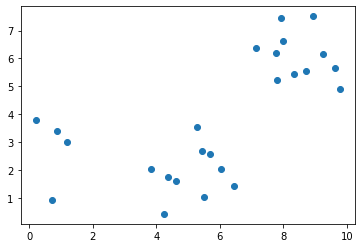

In [3]:
plt.scatter(xvec, yvec)

In [4]:
# Quick loop to try all split values
# Fit the mean on the left and mean on the right
# calculate the total mean-squared error

print('splt', 'mn_l','mn_r', 'mse') 

for split_val in np.unique(xvec)[:-1]:
    a_val = np.mean(yvec[xvec<=split_val])
    b_val = np.mean(yvec[xvec>split_val])
    error_1 = (yvec[xvec<=split_val] - a_val)**2
    error_2 = (yvec[xvec>split_val] - b_val)**2
    error = np.mean(np.concatenate((error_1, error_2)))
    print(split_val, np.round(a_val,decimals=3), 
          np.round(b_val, decimals=3), np.round(error,decimals=3))

splt mn_l mn_r mse
0.2 3.79 3.898 4.675
0.71 2.355 4.028 4.469
0.87 2.703 4.056 4.482
1.18 2.778 4.107 4.438
3.83 2.632 4.21 4.277
4.24 2.267 4.408 3.839
4.38 2.194 4.555 3.552
4.61 2.121 4.728 3.196
5.29 2.279 4.802 3.208
5.45 2.319 4.944 3.022
5.49 2.203 5.223 2.428
5.68 2.233 5.427 2.13
6.03 2.218 5.71 1.631
6.46 2.161 6.099 0.855
7.15 2.443 6.071 1.516
7.78 2.676 6.059 2.039
7.81 2.826 6.164 2.251
7.92 3.083 5.979 2.985
7.99 3.271 5.868 3.444
8.33 3.379 5.956 3.612
8.7 3.481 6.06 3.782
8.92 3.665 5.577 4.289
9.26 3.773 5.29 4.506
9.64 3.852 4.91 4.632


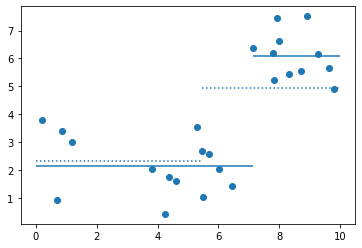

In [5]:
# Plot best split found (and another lesser split as dotted line)
plt.scatter(xvec, yvec)
plt.hlines(y=2.16, xmin=0, xmax=7.15)
plt.hlines(y=6.09, xmin=7.15, xmax=10)
plt.hlines(y=2.319, xmin=0, xmax=5.45, linestyles='dotted')
plt.hlines(y=4.944, xmin=5.45, xmax=10, linestyles='dotted')

### Question 1: What about when I want multiple steps?
- Let $m$ be number of different x values
- To check every division into two steps takes $m$ evaluations
- To check every division into three steps takes $m^2$ evaluations
- etc....

### Question: What about when I have multiple variables?
- Again, to find the best step function with (for example) 8 leaves and 4 variables would be very difficult

### Solution: Use a *greedy* approach
- Find the best split across all variables
- Repeat process on each side of split separately (using only data on that side of split)
- Stop according to some rules
- Note: This does not find the best possible tree!  For example, it may be that you get the best tree by choosing a "not-so-good" split first, but it enables better splits below.

### Question: What happens as I keep splitting more and more?

### Parameters for decision tree algorithm
(I put the sklearn names below, other packages may vary in their naming)
- `max_depth`: don't split further when you've reached a certain depth
- `min_samples_split`: don't split if you have few data points at the node
- `min_samples_leaf`: don't split if it creates a node with few data points
- `criterion`: how to evaluate how "good" a split is.  Typically use mean_squared_error for regression and entropy for classification (though "gini" is also used as a quicker approximation to entropy).  In practice, the distinction between entropy and gini is usually not that important.

### Implementation details:
- Where should I put the split_value if there are no x values between 1.18 and 3.83 (but that is the best split)?
- In other words, for future values between 1.18 and 3.83, should they go "left" or "right"
- What about missing values?
- What about categorical variables?

## Forests of Decision Trees: Motivating thought experiment
- In practice, it is rare to use a single decision tree as your model (though it does happen!)
- Imagine you build a decision tree, and at the root it is very close between two different variables as to which is the best to split on.
- The "best" tree $T_1$ gives a reasonable model. However, you also check what tree you would have built if you used the second-best split (at the root) (call it $T_2$).
- Then you average the predictions of $T_1$ and $T_2$ and find it does better than either tree alone
- You would like to expand this idea and build 1000 trees that are all "pretty good" and also different from one another.
- IDEA: inject some randomness into tree building process...

### Injecting Randomness
When building a forest, one builds many decision trees independently.  Since the decision tree algorithm is deterministic, if you run it over and over again on the same dataset, you will just get the same tree over and over.

#### Randomness 1
Use different datasets each time.  Specifically, take a random sample of your data (how big? with or without replacement?).  This is called "bagging".  This means you can get different trees because the data looks different.
- This helps, but the trees end up still being pretty similar most of the time

#### Randomness 2
Only evaluate a subset of the predictors at each node.  For example, if you have 10 predictors, randomly choose 3 and only consider those.  This means the root splits (and subsequent splits) will be quite different from tree to tree.

Since each tree is a completely independent trial of this process, it is straightforward to parallelize.

### Parameters for Random Forest (in addition to Decision Tree)
- all the tree-specific parameters above
- `n_estimators`: Number of trees to fit
- `max_features`: How many (or what percentage) of the features to try at each node.

## Gradient Boosting: History and Terminology

- Generally, when people refer to "Gradient Boosting" what they really mean is "Gradient Boosted Decision Trees"
- "Boosting" in general, originally referred to a process where you fit a model, and then gave more weight to the examples in the training data that it got wrong, refit the model, and then added the new model to the previous one.  
- AdaBoost (Freund and Schapire) was an early example of this, and using trees as the base learner was shown to be quite effective

- Later, it was shown that AdaBoost was equivalent to fitting the base learner to the *gradient* of a particular loss function (exponential). 

- The idea was then generalized to any particular loss function, and referred to as *gradient boosting*.  Additionally, other loss functions were shown to be better in practice than the exponential loss.

- Though the idea can apply to any base learner, decision trees have been most effective.  So, what we are learning about today is *gradient boosting with decision trees as the base learner* or *gradient boosted decision trees* (but usually just called *gradient boosting*)

### Gradient boosting: rough pass
- Consider a regression problem.  Suppose you have a model $M_1$ that already performs reasonably well.  But you would like to improve it if possible.
- You use your model to make predictions on the training data and measure the *residuals*: i.e. the difference between the true answer and the prediction.
- Next, you build a decision tree to try and predict the *residuals* given your predictors.  For example you want to find a tree that can distinguish between the cases where your previous model underpredicted vs overpredicted (and also distinguish between a small under/overprediction and a large under/overprediction)
    
- In theory, if your new tree does a great job at predicting the residuals, you can add the result of the tree to the previous model, and voila, you will have a better model.
- In reality we need to be concerned with overfitting: Suppose the residuals are truly random noise.  With enough predictors, you may find an incidental pattern that works on your training data, but is worthless on new cases.
- Therefore, we do a few things to try to prevent this from happening (i.e. to help *regularize*)
- Most importantly, rather than directly add the new model to the old model, we first multiply it by a small fraction (say .1 or even .01 or .001).  We will do this process many times, so it doesn't (generally) hurt to take small steps.
- It also doesn't matter whether we start with a "pretty good" model.  We can start with a "nothing" model (predict 0 for everything) and still iterate through this process.

## Wait! This makes sense, but I still don't get a few things...
- Where does the loss function come in?
- Where does the gradient come in?
- What if I am doing a classification problem?

## Good questions!
- What I just described was specific to regression.
- In fact, it was specific to regression with a mean squared error loss function
- When using mean squared error, the derivative of the loss function is the residual (distance from the true answer) (times a constant of 2)
- $\frac{\partial}{\partial y} (y -y_t)^2 = 2(y-y_t)$
- So fitting a model to the residuals is *equivalent* to fitting a model to the *gradient of the loss function*
- So the notion of predicting small/large under/overpredictions can be thought of as predicting where my loss is increasing/decreasing by a small/large amount.
- The latter notion will even generalize to cases where the loss function has a weirder form.


## Reiteration of Gradient Boosting
- In general, (for classification, regression with any loss function) we take the current model, use it to make predictions on the training data, and then find the *derivative of the loss function* for each point *at its current predicted value*.
- For most loss functions, the gradient is "steeper" the further you are from the right answer, so the idea of predicting the "degree" of over/underprediction is still the right one.

### Example of a regression loss function

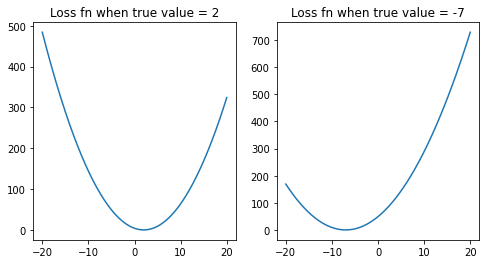

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tvec1 = np.linspace(-20,20,201)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec1, (tvec1-2)**2)
plt.title('Loss fn when true value = 2')

plt.subplot(1,2,2)
plt.plot(tvec1, (tvec1-(-7))**2)
plt.title('Loss fn when true value = -7');

### Example of classification (cross-entropy) loss function

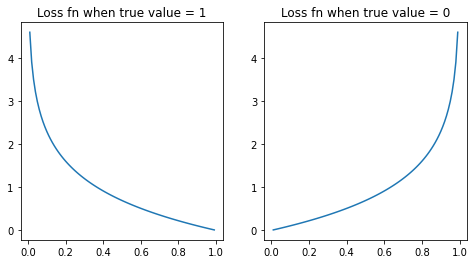

In [7]:
tvec = np.linspace(.01,.99,99)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(tvec, np.log(1/tvec))
plt.title('Loss fn when true value = 1')

plt.subplot(1,2,2)
plt.plot(tvec, np.log(1/(1-tvec)))
plt.title('Loss fn when true value = 0');


## Detailed steps
- Let $M_0$ be the current model
- Let $y_0$ be the current model's predictions on the training set
    - These will be point estimates for regression
    - These will be predicted probabilities for classification
- Let $y_t$ be the true answers (numbers for regression, 0/1 for classification)
- Let $L(y_{true}, y_{pred})$ be the loss function.
- Let $L^{\prime}_{y_{true}}(y_{pred}) = \frac{\partial}{\partial y_{pred}}(L(y_{true}, y_{pred}))$
- Let $z = L^{\prime}_{y_t}(y_1)$ -- i.e. the derivative of the loss function (with respect to the prediction) evaluated at each pair of (true, predicted) values.
- Finally, fit a decision tree that tries to predict $z$ using your predictors $X$.
    - Call the resulting tree $T_1$.
- Let $M_1 = M_0 + \epsilon T_1$ (epsilon is the "learning rate")
- Repeat with $M_1$ as the current model to build $T_2$  (etc. etc.)


### Alternate interpretation: 
- We are doing "gradient descent" by building trees

# Break / Q&A

# Beyond Regression: Section 3
- ## Building Gradient Boosting Models

# Model Building Principles
- ### Explore and interrogate your data
- ### Start with a simple baseline model
- ### Always use early stopping
- ### Tune the max_depth first
- ### Save "big" hyperparameter tuning until the end
- ### Check where your model is doing poorly
- ### Try to engineer features to address model shortcomings
    - #### Use domain expertise / common knowledge

In [8]:
## Check these versions - if you have something different, and run into problems, you may
## want to upgrade (or downgrade) to these versions
## In particular, Pandas v2 has problems with CatBoost compatibility
xgb.__version__, pd.__version__,  sns.__version__, hp.__version__, stb.__version__

('1.7.5', '1.4.4', '0.12.2', '0.2.7', '0.4.3')

In [9]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Ames Housing Data

We'll start by using the Ames housing data.

In [10]:
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')
df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'].fillna(0, inplace=True)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style   

In [11]:
df_house.sample(5)

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
311     312  914476520           20        RL         129.0      9196   Pave   
1025   1026  527354160           60        RL          80.0     10400   Pave   
1588   1589  923202005           90        RM          97.0      8940   Pave   
388     389  527375180           20        RL          78.0     10140   Pave   
537     538  531369020           20        RL          76.0     10141   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
311    NaN       IR1          Lvl    AllPub     Inside        Gtl   
1025   NaN       Reg          Lvl    AllPub     Inside        Gtl   
1588   NaN       IR1          Lvl    AllPub     Corner        Gtl   
388    NaN       Reg          Lvl    AllPub     Inside        Gtl   
537    NaN       IR1          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
311       Mitchel        Norm        Norm      1Fam      1Story             7   
1025       NWAmes        Norm        Norm      1Fam      2Story             7   
1588      Mitchel        Norm        Norm    Duplex      SFoyer             7   
388        NWAmes        Norm        Norm      1Fam      1Story             6   
537       SawyerW        Norm        Norm      1Fam      1Story             8   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
311              5        2003            2003      Gable   CompShg   
1025             6        1980            1988      Gable   CompShg   
1588             5        1997            1998      Gable   CompShg   
388              6        1974            1974        Hip   CompShg   
537              5        2004            2004      Gable   Tar&Grv   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
311       VinylSd      VinylSd         None           0.0         Gd   
1025      HdBoard      HdBoard      BrkFace         280.0         TA   
1588      VinylSd      VinylSd      BrkFace         200.0         TA   
388       Plywood      Plywood      BrkFace         196.0         TA   
537       VinylSd      VinylSd      BrkFace         264.0         Gd   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
311          TA      PConc        Ex        TA            No            Unf   
1025         TA     CBlock        Gd        TA            Mn            Unf   
1588         Gd      PConc        Gd        Gd            Gd            GLQ   
388          TA     CBlock        TA        TA            No            ALQ   
537          TA      PConc        Gd        TA            Gd            BLQ   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
311            0.0            Unf           0.0       1560.0         1560.0   
1025           0.0            Unf           0.0        738.0          738.0   
1588        1309.0            Unf           0.0         35.0         1344.0   
388          888.0            Unf           0.0        228.0         1116.0   
537          516.0            Rec         774.0        222.0         1512.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
311     GasA         Ex           Y      SBrkr        1560           0   
1025    GasA         TA           Y      SBrkr        1277         767   
1588    GasA         Ex           Y      SBrkr        1344           0   
388     GasA         Ex           Y      SBrkr        1116           0   
537     GasA         Ex           Y      SBrkr        1512           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
311                 0         1560             0.0             0.0          2   
1025                0         2044             0.0             0.0          2   
1588                0         1344             2.0             0.0          2   
388                 0         1116          

In [12]:
# There are lots of features here...
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [13]:
# Let's focus on a smaller subset of features...
feat_1 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']


In [14]:
X = df_house.iloc[:,:-1]  # everything except Sale Price
y = df_house.SalePrice 

In [15]:
X_train_full, X_test, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

In [16]:
X.loc[:,feat_1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Lot Area        2925 non-null   int64  
 1   Overall Qual    2925 non-null   int64  
 2   Overall Cond    2925 non-null   int64  
 3   Year Built      2925 non-null   int64  
 4   Year Remod/Add  2925 non-null   int64  
 5   Gr Liv Area     2925 non-null   int64  
 6   Full Bath       2925 non-null   int64  
 7   Half Bath       2925 non-null   int64  
 8   Bedroom AbvGr   2925 non-null   int64  
 9   Garage Area     2925 non-null   float64
 10  Fireplaces      2925 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 274.2 KB


### Explore and interrogate the data
- It is a good habit to look at the data before modeling.  You will often learn about various "idiosyncracies" in your data.  Knowing these may help you understand aspects of your model performance down the road.

- For regression problems, the `pairplot` in the seaborn package is a nice way to look at all of the bivariate relationships.  

- You should also understand distribution of the target variable (and know its mean).

In [17]:
# Get the mean of your target variable
np.mean(df_house.SalePrice)

180411.5747008547

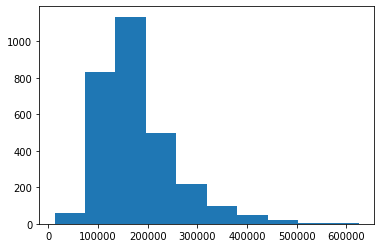

In [18]:
# Make a histogram - doesn't look great at first
plt.hist(df_house.SalePrice);

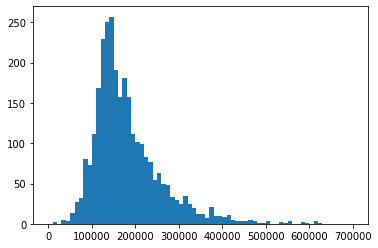

In [19]:
# Redo the histogram with "nicer" bins
binpts = np.linspace(0,700000, 70+1)
plt.hist(df_house.SalePrice, bins=binpts);

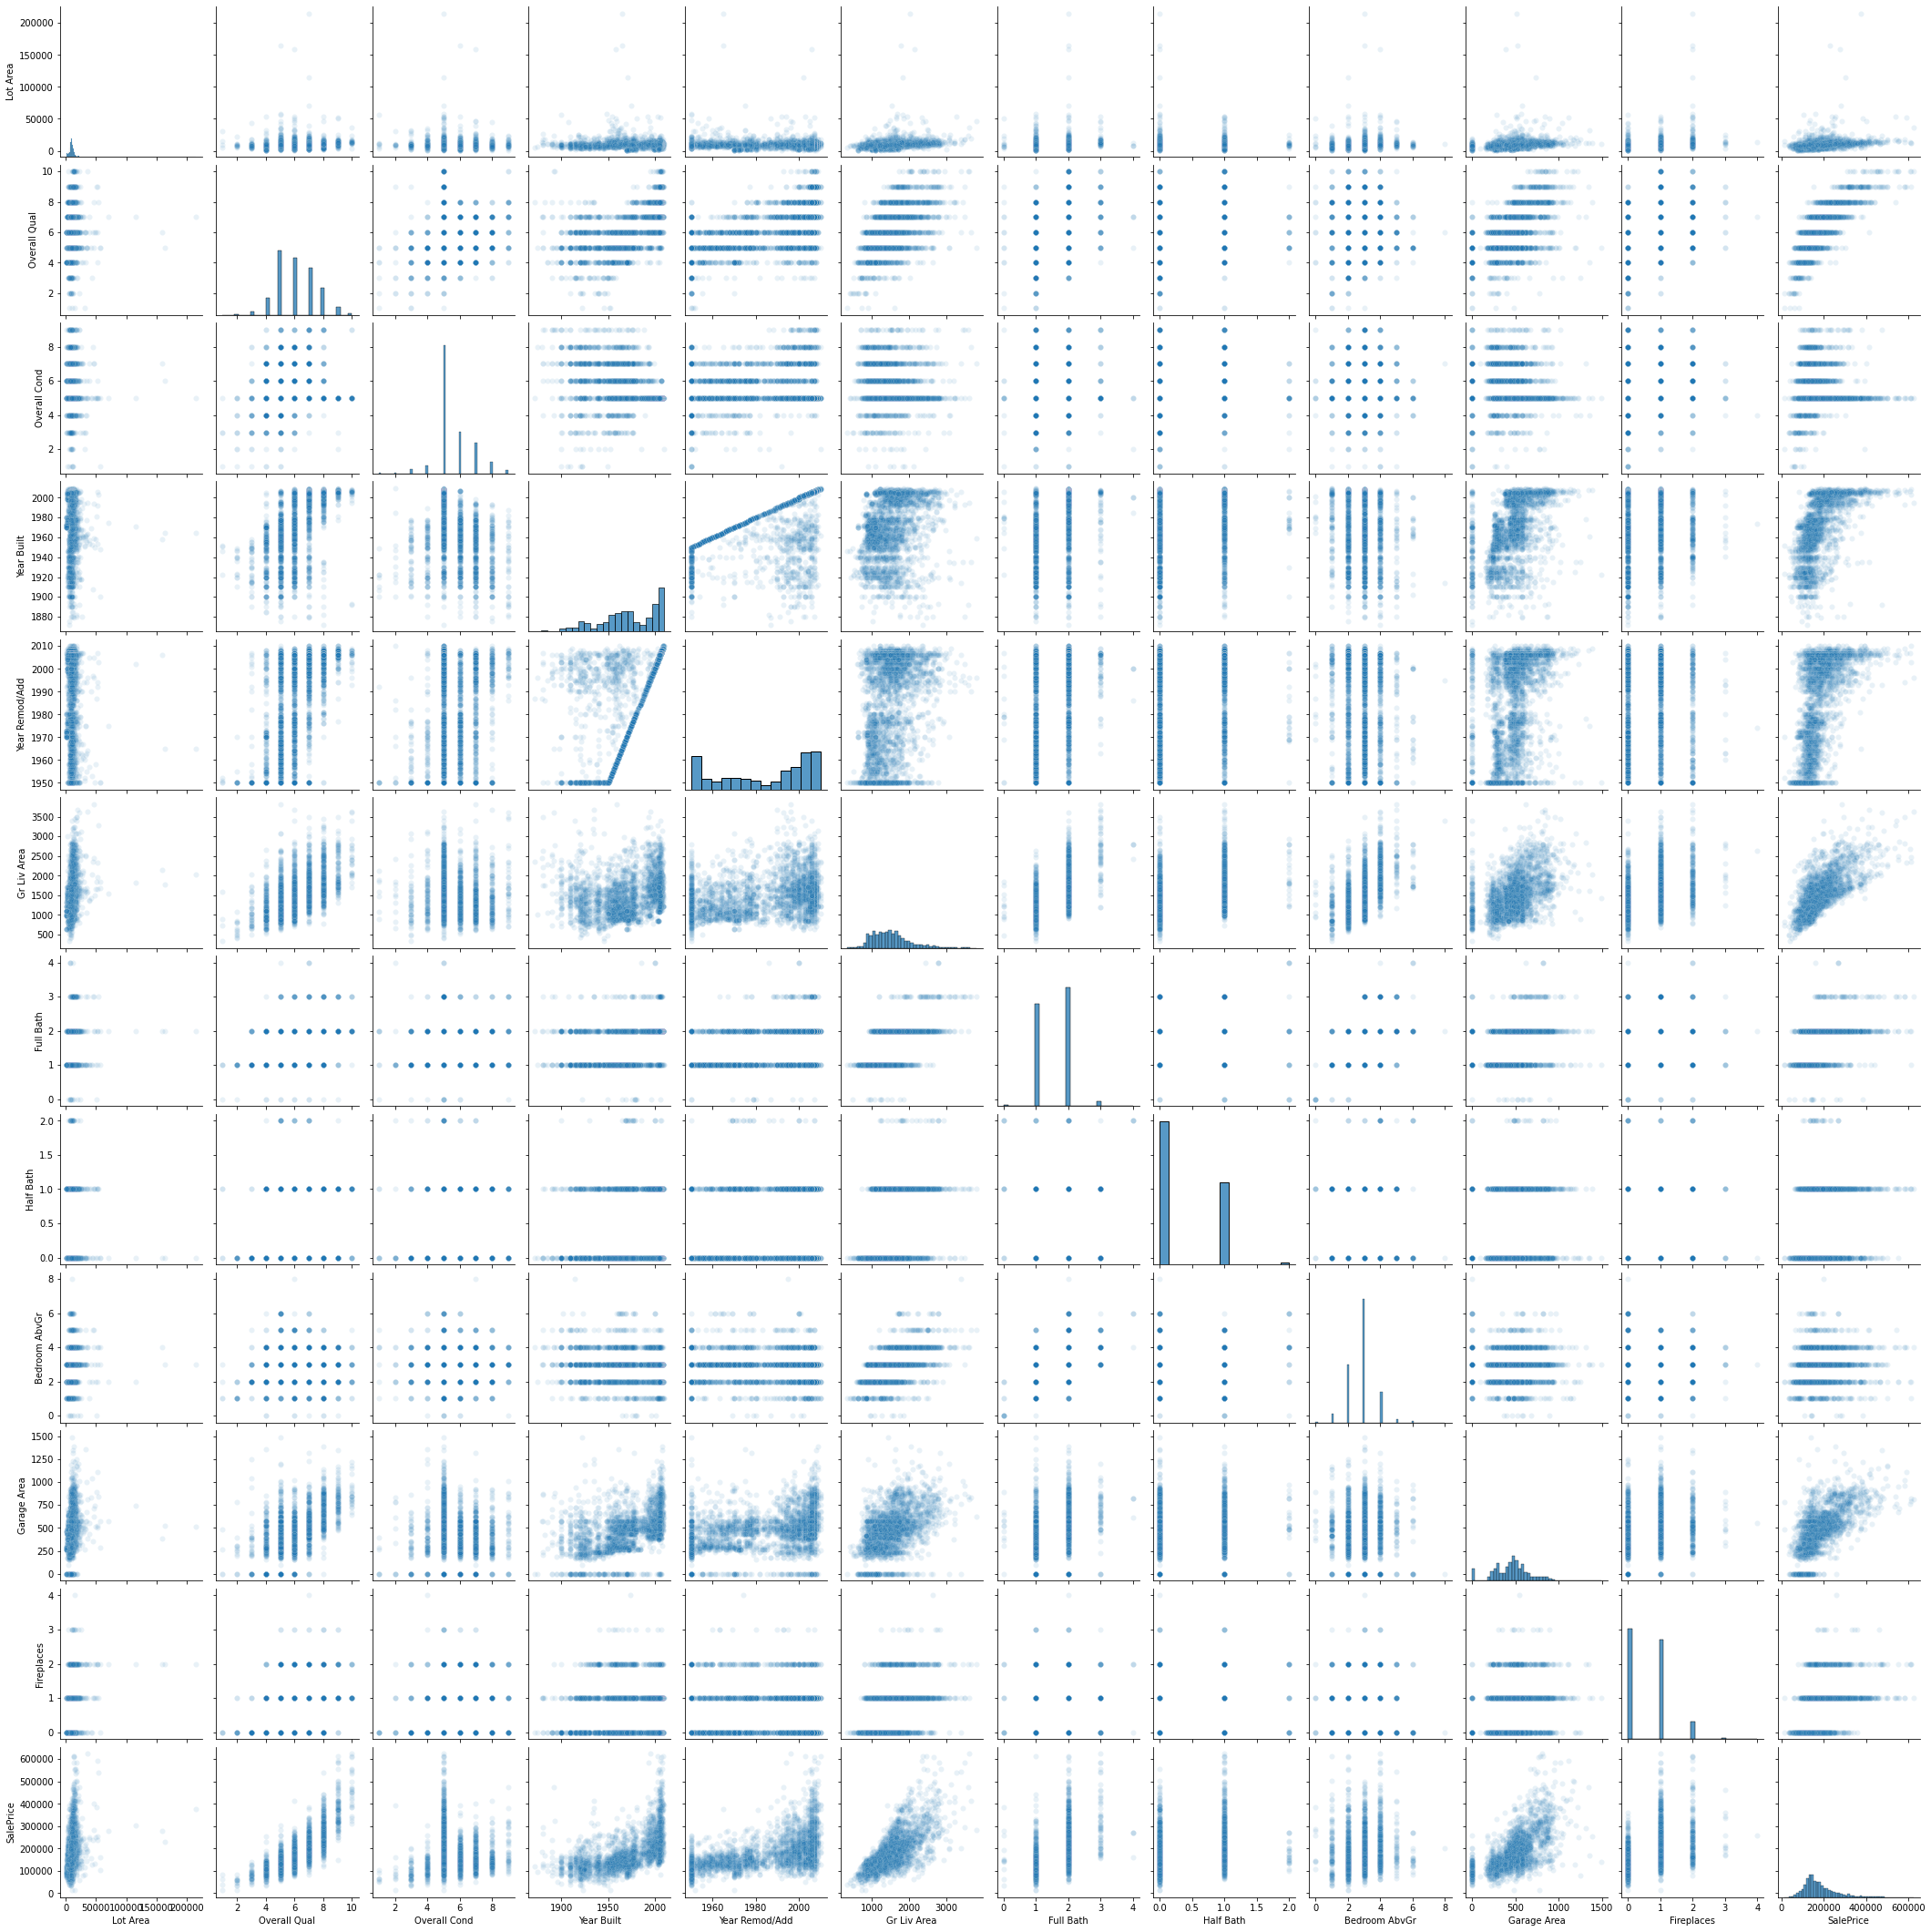

In [20]:
# do a pairplot - this may take a minute or two to complete
sns.pairplot(df_house.loc[:,feat_1+['SalePrice']], plot_kws={'alpha':.1});

## Questions
- What variables seem to have the strongest relationship with the SalePrice?
- What is going on with 'Year Built' and 'Year Remod/Add'?

## Start with a simple baseline model
- Often people start modeling by assembling all the relevant features, trying automated feature selection and massive grid searches to get the best model.
- This typically results in a model with lots of features that are basically irrelevant.
- It is costly to have lots of features in your model!
    - Every feature is a potential failure point
- In most cases, can get most of the performance from relatively few features


In [21]:
feat_0 = ['Lot Area',
 'Overall Qual',
 'Year Built',
 'Gr Liv Area',
 'Bedroom AbvGr']

In [22]:
# create data sets of just the smaller subset of features
X_train_0 = X_train_full.loc[:, feat_0]
X_test_0 = X_test.loc[:, feat_0]

In [23]:
# Create / train Random Forest on just 5 variables
rf0 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf0.fit(X_train_0, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [24]:
preds_rf0 = rf0.predict(X_test_0)

In [25]:
# Get RMSE and MAE of the predictions
np.sqrt(mean_squared_error(y_test, preds_rf0)), mean_absolute_error(y_test, preds_rf0), r2_score(y_test, preds_rf0)

(26286.11328458605, 18484.43099376375, 0.8743851214190691)

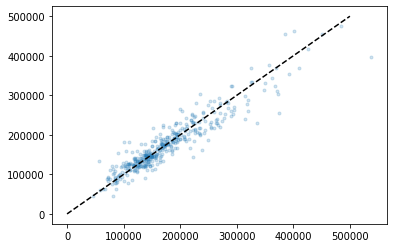

In [26]:
# Plot predicted (y) vs actual (x)
plt.scatter(y_test, preds_rf0, alpha=.2, marker='.')
plt.plot([0,500000],[0,500000], 'k--')

In [27]:
# create data sets of the set of 11 features
X_train_1 = X_train_full.loc[:, feat_1]
X_test_1 = X_test.loc[:, feat_1]

In [28]:
# Create / train Random Forest on 11 variables
rf1 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf1.fit(X_train_1, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [29]:
preds_rf1 = rf1.predict(X_test_1)

In [30]:
# Get RMSE and MAE of the predictions
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1), r2_score(y_test, preds_rf1)

(23243.51180505942, 16141.480664771823, 0.9017818334713157)

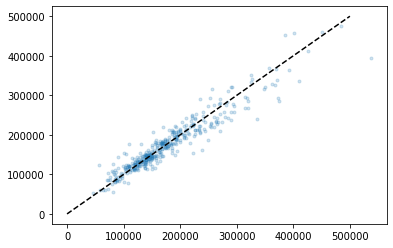

In [31]:
# Plot predicted (y) vs actual (x)
plt.scatter(y_test, preds_rf1, alpha=.2, marker='.')
plt.plot([0,500000],[0,500000], 'k--')

## XGBoost
XGBoost first came out in 2015.  The acronym is "eXtreme Gradient Boosting".  It implemented a number of theoretical and practical improvements, many of which have become standard in subsequent packages:

- *Native handling of missing data*: (Missing values are checked to see if they "fit" better on the left or right side of the tree for each split values)
- *Newton steps*: rather than just finding the gradient, XGBoost also looks at the second derivative to determine the step size.
- *Advanced Regularization*: XGBoost rederived the math to flexibly incorporate *shrinkage* (similar to Lasso/Ridge Regression) and penalize the number of splits.
- *Not checking every split*: XGBoost had a method for deriving quantiles to avoid checking every split (particularly in large datasets when a predictor has a large number of possible values).  Though not the default, this has since been shown to be effective both for speeding up the training *and* as another source of regularization
- *Distributed training*: XGBoost had implementations for working with large datasets that are not held in memory.

In [32]:
# First let's use an XGBoost model with default parameters
xgb_def = xgb.XGBRegressor()
xgb_def

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
xgb_def.fit(X_train_1, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
preds_xgb_def = xgb_def.predict(X_test_1)

In [35]:
# Does slightly worse than Random Forest
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def), r2_score(y_test, preds_xgb_def)


(23693.223543591423, 16741.70330078125, 0.8979444479242334)

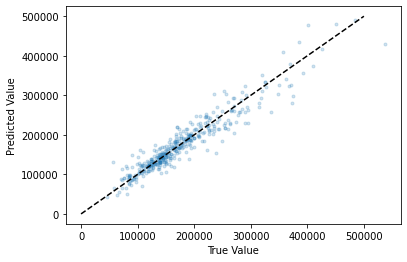

In [36]:
plt.scatter(y_test, preds_xgb_def, alpha=.2, marker='.')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.plot([0,500000],[0,500000], 'k--')

## Hyperparameter Optimization - Practical Considerations
- How much is it worth to improve (metric) by x ? (From a business / practical point of view)
- How much time / computing do I want to spend on improvement?
- How often will I be re-training / re-implementing this model?
- What is the value of knowing / understanding this dataset / model really well?


## Boosting Parameters

- The three most important parameters in your boosting model are the *max_depth*, *learning_rate*, and *n_estimators*.  
- Setting these is made more challenging by the fact that they are highly interactive
- The best way to handle this is:
    - Set aside a validation set for early stopping
    - Use a low-ish `learning rate`
    - Use a high `n_estimators` (we will early stop)
    - Stop when performance on the validation set begins to degrade
    
XGBoost makes it easy to implement early stopping, as we demonstrate below:


In [37]:
xgb1 = xgb.XGBRegressor(n_estimators=5000, learning_rate=.01)
xgb1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
xgb1.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
        early_stopping_rounds = 10)

[0]	validation_0-rmse:190622.94675
[1]	validation_0-rmse:188799.16001
[2]	validation_0-rmse:186988.57350
[3]	validation_0-rmse:185196.73902
[4]	validation_0-rmse:183442.80466
[5]	validation_0-rmse:181691.14089
[6]	validation_0-rmse:179967.47076
[7]	validation_0-rmse:178238.39707
[8]	validation_0-rmse:176540.64069
[9]	validation_0-rmse:174861.69277
[10]	validation_0-rmse:173203.03921
[11]	validation_0-rmse:171558.98288
[12]	validation_0-rmse:169934.59951
[13]	validation_0-rmse:168310.42499
[14]	validation_0-rmse:166720.47618
[15]	validation_0-rmse:165134.42401
[16]	validation_0-rmse:163563.97674
[17]	validation_0-rmse:162016.99210
[18]	validation_0-rmse:160483.75107
[19]	validation_0-rmse:158970.16473
[20]	validation_0-rmse:157458.84070
[21]	validation_0-rmse:155976.30539
[22]	validation_0-rmse:154511.63742
[23]	validation_0-rmse:153060.25445
[24]	validation_0-rmse:151621.30345
[25]	validation_0-rmse:150206.24369
[26]	validation_0-rmse:148796.90212
[27]	validation_0-rmse:147398.58461
[2

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-rmse:108548.43754
[61]	validation_0-rmse:107556.55608
[62]	validation_0-rmse:106589.51496
[63]	validation_0-rmse:105627.96518
[64]	validation_0-rmse:104672.17242
[65]	validation_0-rmse:103726.61856
[66]	validation_0-rmse:102813.97079
[67]	validation_0-rmse:101896.34084
[68]	validation_0-rmse:100984.60734
[69]	validation_0-rmse:100095.91066
[70]	validation_0-rmse:99200.95511
[71]	validation_0-rmse:98321.44402
[72]	validation_0-rmse:97455.74371
[73]	validation_0-rmse:96590.60885
[74]	validation_0-rmse:95740.80822
[75]	validation_0-rmse:94894.99838
[76]	validation_0-rmse:94060.97995
[77]	validation_0-rmse:93240.20507
[78]	validation_0-rmse:92427.56934
[79]	validation_0-rmse:91614.03045
[80]	validation_0-rmse:90814.76252
[81]	validation_0-rmse:90015.88635
[82]	validation_0-rmse:89231.38375
[83]	validation_0-rmse:88461.49698
[84]	validation_0-rmse:87697.81240
[85]	validation_0-rmse:86934.17172
[86]	validation_0-rmse:86176.74605
[87]	validation_0-rmse:85437.00773
[88]	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [39]:
preds_xgb1 = xgb1.predict(X_test_1)


In [40]:
np.sqrt(mean_squared_error(y_test, preds_xgb1)), mean_absolute_error(y_test, preds_xgb1), r2_score(y_test, preds_xgb1)

(22922.514079901484, 15982.38033203125, 0.9044759276769831)

In [41]:
# Compared to last model
np.sqrt(mean_squared_error(y_test, preds_xgb_def)), mean_absolute_error(y_test, preds_xgb_def), r2_score(y_test, preds_xgb_def)

(23693.223543591423, 16741.70330078125, 0.8979444479242334)

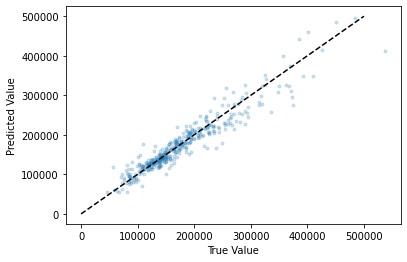

In [42]:
plt.scatter(y_test, preds_xgb1, alpha=.2, marker='.')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.plot([0,500000],[0,500000], 'k--')

In [43]:
# Now let's tune the max depth

md_vals_vec=list(range(1,9))
rmse_vec = np.zeros(len(md_vals_vec))
for i,md in enumerate(md_vals_vec):
    print(f'Training with max_depth {md}')
    xgb_temp = xgb.XGBRegressor(max_depth=md, 
                        n_estimators=5000, learning_rate=.01, 
         early_stopping_rounds = 10) #, early_stopping_rounds=10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))
    
## Note - for newer versions of xgboost, this might scream at you....


Training with max_depth 1
Training with max_depth 2
Training with max_depth 3
Training with max_depth 4
Training with max_depth 5
Training with max_depth 6
Training with max_depth 7
Training with max_depth 8


21631.226970898882

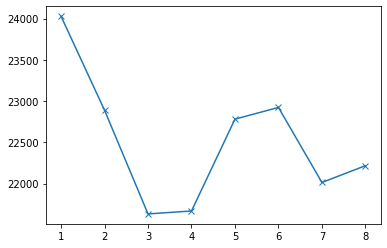

In [44]:
# Plot performance vs. max_depth
plt.plot(md_vals_vec, rmse_vec, marker='x')
np.min(rmse_vec)

### Other boosting parameters
Thus far we have focused our attention on the `max_depth`, `learning_rate`, and `n_estimators`.  Indeed, these are the most important parameters to get right.  However, there are other parameters that can yield improvements if tuned appropriately.  These parameters fall into several groups, and different packages handle them (and name them) differently.


#### Data (row) sampling parameters
How to choose the data for each tree.  Unlike Random Forest, "Standard" boosting just uses the whole data set for each tree.  However, you can choose to sample the data (with or without replacement) to add regularization.
- subsample, replacement, etc.

#### Feature sampling parameters
Unlike Random Forest, the default in gradient boosting is to check every feature at every node.  Since boosting is not relying on having uncorrelated trees, it can still give good results without this randomization.  However, randomly sampling features can help regularize, in addition to speeding up training (it is faster to train if you don't check every column every time). Some packages permit subsampling features per tree, level, *and* node.
- Examples: colsample_bynode, colsample_bytree, colsample_bylevel

#### Split sampling parameters
For each feature, should we check all possible splits, or reduce the number somehow
- Examples: tree_method, sketch_eps in XGBoost



#### Regularization parameters
Other regularization parameters include:
- minimum "improvement" required to make a split
- "Shrinkage" of the leaf values of the trees (as in LASSO / Ridge regression)
- gamma, reg_lambda, reg_alpha



## Setting Parameters in Gradient Boosting
There are several approaches to finding the best parameters for your Gradient Boosting Model
1. Do a massive "grid search"
2. Just play around manually
3. "Smart" parameter search that tries to search promising combinations

There are drawbacks to all of these:
- Grid search is extremely time consuming
- It is difficult to know if you are choosing appropriate parameters and ranges
- There may be other considerations than just metric performance (model size, coherence, training time)
- Manual approaches are haphazard, attention consuming
- Smart approaches are not always as smart as they could be

## Suggested hybrid approach
1. Use early stopping, low learning rate, high number of trees (to remove learning rate and number of estimators from the search)
1. Run hyperopt with a few parameters (including max_depth) to "understand the landscape"
1. Iteratively refine your ranges and add more parameters to the search

#### Summary: Look around *before* doing long iterations

## Let's manually explore some parameters one by one...

In [45]:
# Look at subsample first with max_depth at 3
param_vals_vec=[.7,.75,.8,.85,.9,.95,1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=3, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

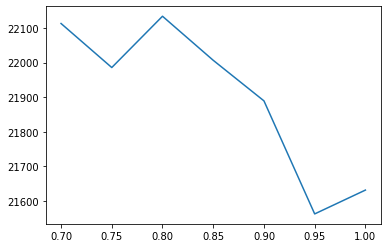

In [46]:
plt.plot(param_vals_vec, rmse_vec)

In [47]:
# Look at subsample with max_depth at 4
param_vals_vec=[.7,.75,.8,.85,.9,.95,1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

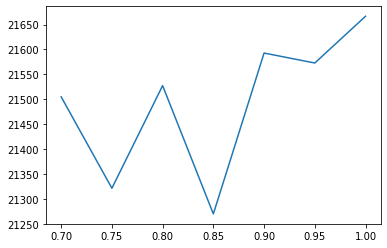

In [48]:
plt.plot(param_vals_vec, rmse_vec);

In [49]:
# Let's set md 4, subsample .85
# and look at the colsample params
param_vals_vec=[.2, .4, .6, .8, 1]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.85, colsample_bynode=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

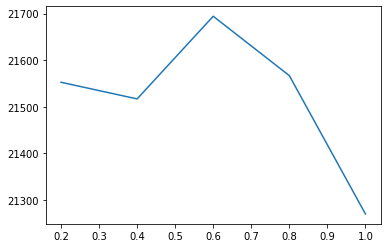

In [50]:
plt.plot(param_vals_vec, rmse_vec);

In [51]:
# Let's set md 4, subsample .85
# now look at the regularization params
param_vals_vec=[1, 2, 3, 5, 10, 20]
rmse_vec = np.zeros(len(param_vals_vec))
for i,param_val in enumerate(param_vals_vec):
    xgb_temp = xgb.XGBRegressor(max_depth=4, 
                        n_estimators=10000, learning_rate=.01,
                        subsample=.85, reg_lambda=param_val, early_stopping_rounds = 10)
    xgb_temp.fit(X_train_1, y_train, 
         eval_set=[(X_test_1, y_test)], 
                 verbose=0)
    preds = xgb_temp.predict(X_test_1)
    rmse_vec[i] = np.sqrt(mean_squared_error(y_test, preds))

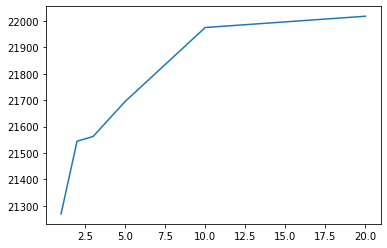

In [52]:
plt.plot(param_vals_vec, rmse_vec);

### Hyperopt Package
Idea: rather than try and exhaustively search a huge parameter space, focus the search on "promising" areas of the search space (based on what you have seen so far).

The `hyperopt` package can be a bit confusing and has some limitations, but overall does a reasonably good job of seraching the parameter space.

Let's see it in action

In [53]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

- First we must define the "loss function"
- This takes a set of parameters and output the loss value

In [54]:
def eval_model(params):
    xgb_base = xgb.XGBRegressor()
    xgb_base.set_params(**params)
    xgb_base.set_params(**{'learning_rate':.01,
                            'n_estimators': 10000,
                            'early_stopping_rounds':20},)
    xgb_base.fit(X_train_1, y_train, eval_set=[(X_test_1, y_test)], 
                 verbose=False)
    preds = xgb_base.predict(X_test_1)
    return(np.sqrt(mean_squared_error(y_test, preds)))

- Next, we define the parameter space.  
- There are several options to define ranges.
    - `randint`: chooses a random integer between a lower and an upper bound
    - `choice`: choose from a set of specific values
    - `uniform`: choose a (float) in the range
    - `quniform`: choose a discrete range of floats
    
See more at hyperopt documentation:
http://hyperopt.github.io/hyperopt/getting-started/search_spaces/


In [55]:
fspace1 = {
    'max_depth':hp.randint('max_depth', 2, 6), # Pythonic - means 2 through 5 inclusive
    'colsample_bynode': hp.uniform('colsample_bynode',.2,1),
    'subsample': hp.quniform('subsample',.3,1,.05)
}

- Finally, we use the `fmin` function and record our trials in a `Trials` object
- you can also specify which algorithm to use (http://hyperopt.github.io/hyperopt/#algorithms) (`tpe.suggest` is "Tree of Parzen Estimators") 


In [56]:
trials1 = Trials()
best = fmin(fn=eval_model, space=fspace1, algo=tpe.suggest, max_evals=100, trials=trials1)

100%|████████| 100/100 [03:41<00:00,  2.22s/trial, best loss: 21052.94808565097]


In [57]:
best

{'colsample_bynode': 0.5025748140642002, 'max_depth': 5, 'subsample': 0.65}

In [58]:
eval_model(best)

21052.94808565097

In [59]:
best_idx = np.argmin([trials1.trials[i]['result']['loss'] for i in range(100)])

In [60]:
trials1.trials[best_idx]

{'state': 2,
 'tid': 35,
 'spec': None,
 'result': {'loss': 21052.94808565097, 'status': 'ok'},
 'misc': {'tid': 35,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bynode': [35], 'max_depth': [35], 'subsample': [35]},
  'vals': {'colsample_bynode': [0.5025748140642002],
   'max_depth': [5],
   'subsample': [0.65]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2023, 7, 11, 22, 6, 42, 896000),
 'refresh_time': datetime.datetime(2023, 7, 11, 22, 6, 44, 382000)}

In [61]:
best

{'colsample_bynode': 0.5025748140642002, 'max_depth': 5, 'subsample': 0.65}

In [62]:
trials1.trials[:2]

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 23243.481171395106, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [0], 'max_depth': [0], 'subsample': [0]},
   'vals': {'colsample_bynode': [0.7333621272046005],
    'max_depth': [2],
    'subsample': [0.55]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 7, 11, 22, 5, 3, 592000),
  'refresh_time': datetime.datetime(2023, 7, 11, 22, 5, 5, 563000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 21485.83662755285, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bynode': [1], 'max_depth': [1], 'subsample': [1]},
   'vals': {'colsample_bynode': [0.4235800507343239],
    'max_depth': [5],
    'subsample': [0.55]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime

In [63]:
md_trial_vals = np.array([t['misc']['vals']['max_depth'] for t in trials1.trials])
csbn_trial_vals = np.array([t['misc']['vals']['colsample_bynode'] for t in trials1.trials])
ss_trial_vals = np.array([t['misc']['vals']['subsample'] for t in trials1.trials])
loss_trial_vals = np.array([t['result']['loss'] for t in trials1.trials])
trial_nums = np.array([t['tid'] for t in trials1.trials])

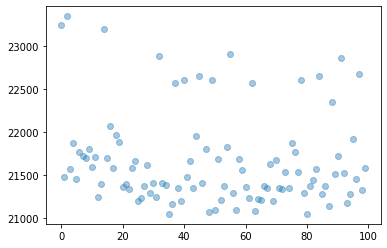

In [64]:
plt.scatter(trial_nums, loss_trial_vals, alpha=.4);

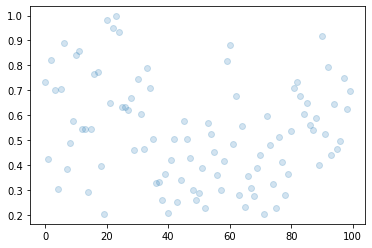

In [65]:
plt.scatter(trial_nums, csbn_trial_vals, alpha=.2);

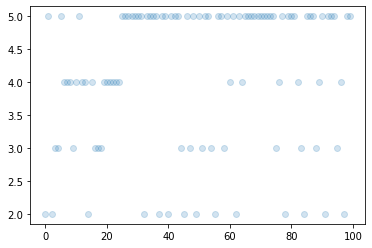

In [66]:
plt.scatter(trial_nums, md_trial_vals, alpha=.2);

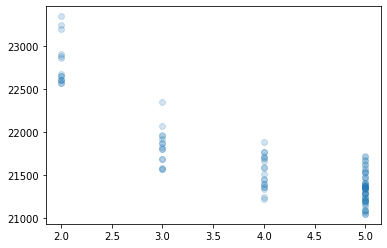

In [67]:
plt.scatter(md_trial_vals, loss_trial_vals, alpha=.2);

### Question:
Based on the above, how might you change the ranges for these parameters next time?

# Final comments on parameter search
- This example was a quite small dataset (~4500 data points), so we were able to run many iterations very quickly.  Typically these searches will take much longer, so it is more important to choose smart ranges.
- Note that lots of combinations gave very good results.  Typically if you get the `max_depth` right (using early stopping) and then pick "pretty good" values for the rest, you will be in good shape
- In practice, other considerations (e.g. model size, parsimony) may come into play.  Generally, you want to pick a "simpler" model if the difference in performance is negligible

## Failure Analysis
- Look at cases where the model performed poorly
- Try to understand why the model's prediction was so different from reality
- See if there is anything in the data that would reflect this reasoning
- Try to adjust model, add / engineer features to capture this useful information
- Rerun model and see if it improves!

In [68]:
best

{'colsample_bynode': 0.5025748140642002, 'max_depth': 5, 'subsample': 0.65}

In [69]:
xgb_best = xgb.XGBRegressor()
xgb_best.set_params(**best)
xgb_best.set_params(**{'learning_rate':.01,
                        'n_estimators': 10000,
                        'early_stopping_rounds':20},)
xgb_best.fit(X_train_1, y_train, eval_set=[(X_test_1, y_test)], 
             verbose=False)
preds_best = xgb_best.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, preds_best))

21052.94808565097

In [70]:
resids = (y_test - preds_best)
abs_resids = np.abs(resids)

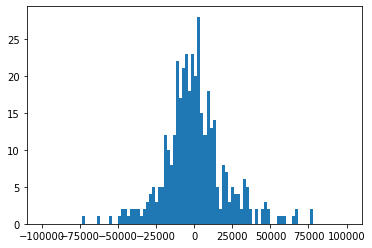

In [71]:
plt.hist(resids, bins = np.linspace(-100000,100000,101));

In [72]:
under_val_test = X_test.loc[resids>30000]
under_val_test

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
2764   2765  906426090           20        RL           NaN     36500   Pave   
263     264  907250030           20        RL          80.0     10389   Pave   
485     486  528280230           60        RL           NaN     12224   Pave   
502     503  528385050           60        RL          79.0      9085   Pave   
1856   1857  533252130           20        RL          90.0     10768   Pave   
2773   2774  907175030           20        RL          70.0      9100   Pave   
2261   2262  916384080           20        RL          64.0      9037   Pave   
2800   2801  907290020           60        RL          75.0      9750   Pave   
2333   2334  527212040           60        RL          82.0     12438   Pave   
1157   1158  533125080           60        RL           NaN      9205   Pave   
2442   2443  528315030           60        RL          82.0      9452   Pave   
529     530  528482130           60        FV          75.0      9375   Pave   
1860   1861  533350020           20        RL          94.0     17778   Pave   
436     437  528118060           60        RL          59.0     23303   Pave   
2883   2884  911370430          120        RM          41.0      5748   Pave   
2479   2480  531451290           60        RL          70.0      9370   Pave   
2457   2458  528429130           20        RL          85.0     10182   Pave   
1070   1071  528180140          120        RL          65.0      8769   Pave   
15       16  527216070           60        RL          47.0     53504   Pave   
2082   2083  905476160           90        RL          42.0      7711   Pave   
2860   2861  909276070           50        RL          80.0     12400   Pave   
2275   2276  921128030           20        RL          85.0     12633   Pave   
2211   2212  909275110           70        RL          60.0      7230   Pave   
1985   1986  902205130           30        RM          50.0      6000   Pave   
924     925  909278020           50        RL          54.0      7681   Pave   
1074   1075  528186130          120        RL          89.0      8232   Pave   
906     907  909129100           50        RH          55.0      4500   Pave   
2023   2024  903401070           50        RL          60.0      8850   Pave   
2759   2760  906392120           20        RL          78.0     11645   Pave   
245     246  906201120           20        RL          83.0     11980   Pave   
728     729  903200080           70        RL         144.0     21384   Pave   
461     462  528186180          120        RL          48.0      6240   Pave   
296     297  909428280           20        RL         100.0     17500   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
2764   NaN       IR1          Low    AllPub     Inside        Mod   
263    NaN       Reg          Lvl    AllPub     Inside        Gtl   
485    NaN       IR1          Lvl    AllPub     Corner        Gtl   
502    NaN       Reg          Lvl    AllPub     Inside        Gtl   
1856   NaN       IR1          Lvl    AllPub     Corner        Gtl   
2773   NaN       Reg          Lvl    AllPub     Inside        Gtl   
2261   NaN       IR1          HLS    AllPub     Inside        Gtl   
2800   NaN       Reg          Lvl    AllPub     Corner        Gtl   
2333   NaN       IR1          Lvl    AllPub     Inside        Gtl   
1157   NaN       IR1          Lvl    AllPub     Inside        Gtl   
2442   NaN       Reg          Lvl    AllPub     Inside        Gtl   
529    NaN       Reg          Lvl    AllPub     Inside        Gtl   
1860   NaN       IR1          Lvl    AllPub     Inside        Gtl   
436    NaN       IR3          Lvl    AllPub    CulDSac        Gtl   
2883   NaN       IR1          HLS    AllPub     Inside        Mod   
2479   NaN       IR2          Lvl    AllPub     Inside        Gtl   
2457   NaN       IR1          Lvl    AllPub    CulDSac        Gtl   
1070   NaN       Reg          Lvl    AllPub

In [73]:
over_val_test = X_test.loc[resids<-30000]
over_val_test

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1462   1463  907260010           60        RL           NaN     11250   Pave   
628     629  535126100           20        RL         120.0     13560   Pave   
104     105  533238045           20        FV          57.0     12853   Pave   
2797   2798  907275030           60        RL           NaN     21533   Pave   
900     901  908275110           20        RL          70.0     11767   Pave   
2381   2382  528106120           20        RL         110.0     16163   Pave   
1052   1053  528104050           20        RL         114.0     14803   Pave   
2335   2336  527216010           60        RL          92.0     15922   Pave   
380     381  527356040           20        RL          82.0     11880   Pave   
966     967  916460110           60        RL          75.0      9157   Pave   
306     307  911204090           20   C (all)          66.0      8712   Grvl   
1693   1694  528106110           20        RL         105.0     15431   Pave   
2246   2247  911370460          120        RM          44.0      4750   Pave   
179     180  902206220           50        RM          69.0     11851   Pave   
1568   1569  914476080           90        RL          76.0     10260   Pave   
1471   1472  907295100           90        RM          83.0     10126   Pave   
1993   1994  902302150          190        RM          85.0     13600   Pave   
1771   1772  528364110           60        RL          65.0     12257   Pave   
2145   2146  907252020           60        RL           NaN      9375   Pave   
2326   2327  527182020          120        RL          30.0      3701   Pave   
169     170  902102100           50        RM          60.0      4800   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1462   NaN       Reg          Lvl    AllPub     Corner        Gtl   
628    NaN       Reg          Lvl    AllPub     Corner        Gtl   
104   Pave       IR1          Lvl    AllPub     Inside        Gtl   
2797   NaN       IR2          Lvl    AllPub        FR2        Gtl   
900    NaN       Reg          Lvl    AllPub     Inside        Gtl   
2381   NaN       Reg          Lvl    AllPub     Corner        Gtl   
1052   NaN       Reg          Lvl    AllPub     Inside        Gtl   
2335   NaN       IR1          HLS    AllPub     Corner        Gtl   
380    NaN       IR1          Lvl    AllPub     Inside        Gtl   
966    NaN       IR1          Lvl    AllPub     Corner        Gtl   
306    NaN       Reg          Bnk    AllPub     Inside        Mod   
1693   NaN       Reg          Lvl    AllPub     Inside        Gtl   
2246   NaN       IR1          HLS    AllPub     Inside        Mod   
179    NaN       Reg          Lvl    AllPub     Inside        Gtl   
1568   NaN       Reg          Lvl    AllPub     Inside        Gtl   
1471   NaN       Reg          Lvl    AllPub     Corner        Gtl   
1993  Grvl       Reg          Lvl    AllPub     Inside        Gtl   
1771   NaN       IR1          Lvl    AllPub     Inside        Gtl   
2145   NaN       Reg          Lvl    AllPub     Inside        Gtl   
2326   NaN       IR1          Lvl    AllPub     Inside        Gtl   
169    NaN       Reg          Lvl    AllPub     Corner        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1462      CollgCr        Norm        Norm      1Fam      2Story             8   
628         NAmes        Norm        Norm      1Fam      1Story             6   
104       Somerst        Norm        Norm      1Fam      1Story             8   
2797      CollgCr       Feedr        Norm      1Fam      2Story             7   
900       Edwards        Norm        Norm      1Fam      1Story             5   
2381      NridgHt        Norm        Norm      1Fam      1Story             8   
1052      NridgHt        PosN        PosN      1Fam      1Story            10   
2335      StoneBr        Norm        Norm      1Fam      2Story             9 

## Exercise
- Explore the columns above of the undervalued and overvalued houses.
- See if any of the columns above look relevant
- Add one in and see if it improves the model!
- OR (for extra credit) engineer a feature based on multiple columns and see if that improves the model


# BREAK / Q & A

## Section 4
# Review of Gradient Boosting Packages
Next we will review LightGBM, CatBoost, and StructureBoost, and discuss their capabilities and limitations.  

## LightGBM
LightGBM came out around 2017 (was in NeurIPS 2017), written mainly by researchers at Microsoft Research.  Its major advances are the following:
- smarter techniques (by default) to avoid searching all splits and speeding things up (ignoring small gradients to reduce data at each iteration)  (Gradient one-sided sampling - GOSS)
- "looks for" mutually exclusive features to handle them better
- handles categorical variables by ranking their marginal target value in each node
- categorical variables *must* be integer encoded
- Is usually quite fast due to GOSS but not always the best performance

In [74]:
import lightgbm as lgbm

In [75]:
lgbm.__version__

'3.3.5'

In [76]:
lgbm.LGBMRegressor?

Init signature:
lgbm.LGBMRegressor(
    boosting_type: str = 'gbdt',
    num_leaves: int = 31,
    max_depth: int = -1,
    learning_rate: float = 0.1,
    n_estimators: int = 100,
    subsample_for_bin: int = 200000,
    objective: Union[str, Callable, NoneType] = None,
    class_weight: Union[Dict, str, NoneType] = None,
    min_split_gain: float = 0.0,
    min_child_weight: float = 0.001,
    min_child_samples: int = 20,
    subsample: float = 1.0,
    subsample_freq: int = 0,
    colsample_bytree: float = 1.0,
    reg_alpha: float = 0.0,
    reg_lambda: float = 0.0,
    random_state: Union[int, numpy.random.mtrand.RandomState, NoneType] = None,
    n_jobs: int = -1,
    silent: Union[bool, str] = 'warn',
    importance_type: str = 'split',
    **kwargs,
)
Docstring:      LightGBM regressor.
Init docstring:
Construct a gradient boosting model.

Parameters
----------
boosting_type : str, optional (default='gbdt')
    'gbdt', traditional Gradient Boosting Decision Tree.
    'dart', Dr

In [77]:
lgbm1 = lgbm.LGBMRegressor(n_estimators=10000, learning_rate=.01, max_depth=4, subsample=.85)

In [78]:
lgbm1.fit(X_train_1, y_train, eval_set=[(X_test_1, y_test)],
                          callbacks=[lgbm.early_stopping(stopping_rounds=10), lgbm.log_evaluation(10)])

Training until validation scores don't improve for 10 rounds
[10]	valid_0's l2: 4.74948e+09
[20]	valid_0's l2: 4.12211e+09
[30]	valid_0's l2: 3.59718e+09
[40]	valid_0's l2: 3.15685e+09
[50]	valid_0's l2: 2.78203e+09
[60]	valid_0's l2: 2.47019e+09
[70]	valid_0's l2: 2.19923e+09
[80]	valid_0's l2: 1.97234e+09
[90]	valid_0's l2: 1.77632e+09
[100]	valid_0's l2: 1.61478e+09
[110]	valid_0's l2: 1.47669e+09
[120]	valid_0's l2: 1.35988e+09
[130]	valid_0's l2: 1.25477e+09
[140]	valid_0's l2: 1.1664e+09
[150]	valid_0's l2: 1.08991e+09
[160]	valid_0's l2: 1.0176e+09
[170]	valid_0's l2: 9.55253e+08
[180]	valid_0's l2: 9.00877e+08
[190]	valid_0's l2: 8.52534e+08
[200]	valid_0's l2: 8.12003e+08
[210]	valid_0's l2: 7.77173e+08
[220]	valid_0's l2: 7.46456e+08
[230]	valid_0's l2: 7.19066e+08
[240]	valid_0's l2: 6.95714e+08
[250]	valid_0's l2: 6.74832e+08
[260]	valid_0's l2: 6.54793e+08
[270]	valid_0's l2: 6.36526e+08
[280]	valid_0's l2: 6.20366e+08
[290]	valid_0's l2: 6.07387e+08
[300]	valid_0's l2: 5.

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=10000,
              subsample=0.85)

In [79]:
lgbm1_preds = lgbm1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, lgbm1_preds))

21451.78955405113

In [80]:
feat_2 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces','Neighborhood']


In [81]:
X_train_2 = X_train_full.loc[:, feat_2]
X_test_2 = X_test.loc[:, feat_2]

In [82]:
X_train_2.Neighborhood.value_counts()

NAmes      380
CollgCr    235
OldTown    206
Edwards    167
Somerst    154
NridgHt    145
Gilbert    141
Sawyer     130
NWAmes     115
SawyerW    112
Mitchel    100
BrkSide     95
Crawfor     85
IDOTRR      81
Timber      62
NoRidge     59
StoneBr     42
ClearCr     40
SWISU       40
BrDale      28
MeadowV     28
Blmngtn     21
NPkVill     21
Veenker     20
Greens       8
Blueste      7
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

In [83]:
mapping_dict = {neigh_name:i for i,neigh_name in enumerate(df_house.Neighborhood.unique())}
mapping_dict

{'NAmes': 0,
 'Gilbert': 1,
 'StoneBr': 2,
 'NWAmes': 3,
 'Somerst': 4,
 'BrDale': 5,
 'NPkVill': 6,
 'NridgHt': 7,
 'Blmngtn': 8,
 'NoRidge': 9,
 'SawyerW': 10,
 'Sawyer': 11,
 'Greens': 12,
 'BrkSide': 13,
 'OldTown': 14,
 'IDOTRR': 15,
 'ClearCr': 16,
 'SWISU': 17,
 'Edwards': 18,
 'CollgCr': 19,
 'Crawfor': 20,
 'Blueste': 21,
 'Mitchel': 22,
 'Timber': 23,
 'MeadowV': 24,
 'Veenker': 25,
 'GrnHill': 26,
 'Landmrk': 27}

In [84]:
X_train_2a = X_train_2.copy()
X_test_2a = X_test_2.copy()

X_train_2a['Neighborhood'] = X_train_2['Neighborhood'].map(lambda x: mapping_dict[x])
X_test_2a['Neighborhood'] = X_test_2['Neighborhood'].map(lambda x: mapping_dict[x])


In [85]:
lgbm2 = lgbm.LGBMRegressor(n_estimators=10000, learning_rate=.01, max_depth=4, subsample=.85, 
                           categorical_feature='name:Neighborhood',
                          num_leaves = 64)

Note: the warnings below are a known issue and hopefully will be resolved in a future version. (See https://github.com/microsoft/LightGBM/issues/3379)

In [86]:
lgbm2.fit(X_train_2a, y_train, eval_set=[(X_test_2a, y_test)], categorical_feature=['Neighborhood'],
         callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Neighborhood']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/brianlucena/.pyenv/versions/3.9.13/envs/ds3913/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in par

Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 4.73633e+09
[20]	valid_0's l2: 4.09872e+09
[30]	valid_0's l2: 3.56518e+09
[40]	valid_0's l2: 3.12055e+09
[50]	valid_0's l2: 2.74994e+09
[60]	valid_0's l2: 2.43815e+09
[70]	valid_0's l2: 2.17382e+09
[80]	valid_0's l2: 1.95161e+09
[90]	valid_0's l2: 1.76024e+09
[100]	valid_0's l2: 1.5992e+09
[110]	valid_0's l2: 1.45854e+09
[120]	valid_0's l2: 1.33378e+09
[130]	valid_0's l2: 1.22827e+09
[140]	valid_0's l2: 1.13994e+09
[150]	valid_0's l2: 1.06466e+09
[160]	valid_0's l2: 9.94467e+08
[170]	valid_0's l2: 9.33245e+08
[180]	valid_0's l2: 8.80405e+08
[190]	valid_0's l2: 8.34873e+08
[200]	valid_0's l2: 7.98165e+08
[210]	valid_0's l2: 7.65635e+08
[220]	valid_0's l2: 7.34123e+08
[230]	valid_0's l2: 7.07349e+08
[240]	valid_0's l2: 6.84131e+08
[250]	valid_0's l2: 6.63156e+08
[260]	valid_0's l2: 6.45846e+08
[270]	valid_0's l2: 6.30055e+08
[280]	valid_0's l2: 6.15483e+08
[290]	valid_0's l2: 6.02755e+08
[300]	valid_0's l2: 5

LGBMRegressor(categorical_feature='name:Neighborhood', learning_rate=0.01,
              max_depth=4, n_estimators=10000, num_leaves=64, subsample=0.85)

In [87]:
lgbm2_preds = lgbm2.predict(X_test_2a)
np.sqrt(mean_squared_error(y_test, lgbm2_preds))

20837.3271887603

## Catboost
Catboost came out around 2017-2018 (paper in NeurIPS 2018), written by a group of researchers at Yandex.  Its major advance was allowing *native handling of categorical variables* (as strings).  Specifically, it does on-the-fly *numerical encoding* of categorical variables, with a clever encoding scheme to reduce overfitting (their paper argues that the standard approach of LightGBM overfits).  It is also highly optimized, very fast.

In [88]:
import catboost as cb

In [89]:
cb1 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=4,
                          early_stopping_rounds=10, eval_metric='RMSE', subsample=.85)

In [90]:
cb1.fit(X_train_1, y_train, eval_set=[(X_test_1, y_test)])

0:	learn: 78673.5672241	test: 73770.7736529	best: 73770.7736529 (0)	total: 56.1ms	remaining: 9m 20s
1:	learn: 78116.4190710	test: 73283.1910098	best: 73283.1910098 (1)	total: 57.1ms	remaining: 4m 45s
2:	learn: 77613.3151732	test: 72838.1760004	best: 72838.1760004 (2)	total: 57.9ms	remaining: 3m 13s
3:	learn: 77146.8460866	test: 72412.7692275	best: 72412.7692275 (3)	total: 58.8ms	remaining: 2m 26s
4:	learn: 76612.0544106	test: 71918.4061911	best: 71918.4061911 (4)	total: 59.6ms	remaining: 1m 59s
5:	learn: 76123.3155100	test: 71462.2589191	best: 71462.2589191 (5)	total: 60.4ms	remaining: 1m 40s
6:	learn: 75630.6081149	test: 71015.1854312	best: 71015.1854312 (6)	total: 61.2ms	remaining: 1m 27s
7:	learn: 75141.5519180	test: 70591.9787521	best: 70591.9787521 (7)	total: 61.9ms	remaining: 1m 17s
8:	learn: 74652.0339559	test: 70132.8546662	best: 70132.8546662 (8)	total: 62.6ms	remaining: 1m 9s
9:	learn: 74183.9445491	test: 69702.1462130	best: 69702.1462130 (9)	total: 63.4ms	remaining: 1m 3s
10

In [91]:
cb1_preds = cb1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, cb1_preds))

22000.001778396

In [92]:
X_train_2.Neighborhood.unique()

array(['CollgCr', 'Edwards', 'BrkSide', 'SWISU', 'NAmes', 'Somerst',
       'Sawyer', 'IDOTRR', 'NWAmes', 'BrDale', 'Crawfor', 'NridgHt',
       'Gilbert', 'Mitchel', 'Timber', 'Greens', 'SawyerW', 'StoneBr',
       'NoRidge', 'ClearCr', 'MeadowV', 'OldTown', 'Blmngtn', 'Veenker',
       'Blueste', 'NPkVill', 'Landmrk', 'GrnHill'], dtype=object)

In [93]:
cb2 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=4,
                          early_stopping_rounds=100, eval_metric='RMSE', cat_features=['Neighborhood'])

In [94]:
cb2.fit(X_train_2, y_train, eval_set=[(X_test_2, y_test)])

0:	learn: 78694.4009027	test: 73768.4579489	best: 73768.4579489 (0)	total: 2.1ms	remaining: 21s
1:	learn: 78151.4843927	test: 73271.2664053	best: 73271.2664053 (1)	total: 4.59ms	remaining: 22.9s
2:	learn: 77612.5508372	test: 72772.1201893	best: 72772.1201893 (2)	total: 6.35ms	remaining: 21.2s
3:	learn: 77078.7882529	test: 72272.8284940	best: 72272.8284940 (3)	total: 7.95ms	remaining: 19.9s
4:	learn: 76553.7490509	test: 71771.7963596	best: 71771.7963596 (4)	total: 9.92ms	remaining: 19.8s
5:	learn: 76033.2526764	test: 71322.8844061	best: 71322.8844061 (5)	total: 11.6ms	remaining: 19.3s
6:	learn: 75526.6408508	test: 70890.2784227	best: 70890.2784227 (6)	total: 13.1ms	remaining: 18.7s
7:	learn: 75020.0708379	test: 70423.1577850	best: 70423.1577850 (7)	total: 14.6ms	remaining: 18.2s
8:	learn: 74515.7530881	test: 69954.6861857	best: 69954.6861857 (8)	total: 16.1ms	remaining: 17.8s
9:	learn: 74036.3393837	test: 69521.1777380	best: 69521.1777380 (9)	total: 17.6ms	remaining: 17.5s
10:	learn: 73

In [95]:
cb2_preds = cb2.predict(X_test_2)
np.sqrt(mean_squared_error(y_test, cb2_preds))

20989.702440093526

### StructureBoost
StructureBoost was released in 2020 (I am the author).  It is based on work I published in AISTATS 2020.  The major advance is the ability to exploit known structure in a categorical variable.

For example, in this problem, if we knew the locations of the neighborhoods (which neighborhoods border which others) we could pass that to the algorithm, and it could make splits based on that.

StructureBoost also has capabilities to incorporate structure in the target variable (for multi-classfication) as well as for probabilistic regression.  We will explore these in the next lessons.

We will only touch on StructureBoost here -- there are many available resources:

YouTube videos:

Categorical Structure:
- https://www.youtube.com/watch?v=u0Wlofm60rA

Intro to StructureBoost
- https://www.youtube.com/watch?v=81h098kJPCQ&t=1s

More new ones coming soon!

In [96]:
stb1 = stb.StructureBoost(max_depth=5, num_trees=10000, learning_rate=.01, mode='regression' )

In [97]:
stb1.fit(X_train_1, y_train, eval_set = (X_test_1, y_test), eval_freq=10, early_stop_past_steps=10)

i=0, eval_set_loss = 5511048427.211516
i=10, eval_set_loss = 4722333334.50514
i=20, eval_set_loss = 4059092501.9826994
i=30, eval_set_loss = 3511298590.5886497
i=40, eval_set_loss = 3059527734.977358
i=50, eval_set_loss = 2676087716.9963775
i=60, eval_set_loss = 2352850143.0370083
i=70, eval_set_loss = 2073291778.4920208
i=80, eval_set_loss = 1844638662.6966157
i=90, eval_set_loss = 1656399263.9594445
i=100, eval_set_loss = 1493748688.1778595
i=110, eval_set_loss = 1356029846.6795216
i=120, eval_set_loss = 1239328316.1787143
i=130, eval_set_loss = 1140012314.5382154
i=140, eval_set_loss = 1052120736.4132549
i=150, eval_set_loss = 976503817.0935489
i=160, eval_set_loss = 912013852.8553247
i=170, eval_set_loss = 856696788.3396709
i=180, eval_set_loss = 807362045.3241595
i=190, eval_set_loss = 767042785.8268286
i=200, eval_set_loss = 729418343.8922026
i=210, eval_set_loss = 695999533.7654911
i=220, eval_set_loss = 666621173.2658844
i=230, eval_set_loss = 640855452.3367368
i=240, eval_set_

In [98]:
stb1_preds = stb1.predict(X_test_1)
np.sqrt(mean_squared_error(y_test, stb1_preds))

21311.157853272016

### Incorporating Structure
I did some work to figure out the layout of the neighborhoods in Ames, and came up with a list of which neighborhoods border which others.  (Though I'm certain there are some mistakes).

Nevertheless, using this information, we can tell StructureBoost about the layout of the neighborhoods, and it can try "spatially aware" splits.

In [99]:
# This is a quick way to get a starting configuration that can be modified
fc_struct = stb.get_basic_config(X_train_2, stb.default_config_dict())
fc_struct

{'Lot Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Qual': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Cond': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Built': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Gr Liv Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Full Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Half Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Bedroom AbvGr': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Garage Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Fireplaces': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Neighborhood': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x1450d6b20>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [100]:
edge_list_ames = [['SawyerW', 'CollgCr'],
 ['SawyerW', 'Sawyer'],
 ['SawyerW', 'StoneBr'],
 ['CollgCr', 'StoneBr'],
 ['CollgCr', 'Edwards'],
 ['Edwards', 'Mitchel'],
 ['Mitchel', 'StoneBr'],
 ['StoneBr', 'MeadowV'],
 ['StoneBr', 'Greens'],
 ['MeadowV', 'Greens'],
 ['MeadowV', 'Sawyer'],
 ['Edwards', 'Sawyer'],
 ['Edwards', 'ClearCr'],
 ['Edwards', 'Greens'],
 ['Edwards', 'SWISU'],
 ['Timber', 'GrnHill'],
 ['IDOTRR', 'GrnHill'],
 ['GrnHill', 'Mitchel'],
 ['IDOTRR', 'Mitchel'],
 ['IDOTRR', 'Crawfor'],
 ['Crawfor', 'SWISU'],
 ['Crawfor', 'Blueste'],
 ['Blueste', 'SWISU'],
 ['BrkSide', 'Crawfor'],
 ['OldTown', 'IDOTRR'],
 ['BrkSide', 'OldTown'],
 ['NAmes', 'BrkSide'],
 ['NAmes', 'OldTown'],
 ['NAmes', 'NWAmes'],
 ['NWAmes', 'NoRidge'],
 ['NWAmes', 'Somerst'],
 ['NoRidge', 'Somerst'],
 ['NoRidge', 'Veenker'],
 ['Veenker', 'ClearCr'],
 ['Veenker', 'Sawyer'],
 ['ClearCr', 'Sawyer'],
 ['Somerst', 'NWAmes'],
 ['Somerst', 'NoRidge'],
 ['NridgHt', 'Somerst'],
 ['NridgHt', 'NoRidge'],
 ['NridgHt', 'Blmngtn'],
 ['Blmngtn', 'StoneBr'],
 ['StoneBr', 'Gilbert'],
 ['NridgHt', 'Gilbert'],
 ['Gilbert', 'BrDale'],
 ['Gilbert', 'NPkVill'],
 ['NPkVill', 'Somerst'],
 ['Landmrk', 'GrnHill'],
 ['Landmrk', 'StoneBr']]

In [101]:
ames_graph = stb.graphs.graph_undirected(edge_list_ames)

In [102]:
fc_struct['Neighborhood']['graph']=ames_graph
fc_struct

{'Lot Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Qual': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Overall Cond': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Year Built': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Gr Liv Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Full Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Half Bath': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Bedroom AbvGr': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Garage Area': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Fireplaces': {'feature_type': 'numerical', 'max_splits_to_search': 25},
 'Neighborhood': {'feature_type': 'categorical_str',
  'graph': <structureboost.graphs.graph_undirected at 0x1460e73a0>,
  'split_method': 'span_tree',
  'num_span_trees': 1}}

In [103]:
stb_struct = stb.StructureBoost(max_depth=5, feature_configs=fc_struct, num_trees=10000, learning_rate=.01, mode='regression' )

In [104]:
stb_struct.fit(X_train_2, y_train, eval_set = (X_test_2, y_test), eval_freq=10, early_stop_past_steps=5)

i=0, eval_set_loss = 5511048427.211516
i=10, eval_set_loss = 4711348131.66313
i=20, eval_set_loss = 4043738712.3224134
i=30, eval_set_loss = 3504015122.973666
i=40, eval_set_loss = 3052551564.952883
i=50, eval_set_loss = 2670594339.7854085
i=60, eval_set_loss = 2348848781.5511646
i=70, eval_set_loss = 2073743029.9735577
i=80, eval_set_loss = 1848642096.4959936
i=90, eval_set_loss = 1662283098.850425
i=100, eval_set_loss = 1501212038.5887513
i=110, eval_set_loss = 1366139683.0121522
i=120, eval_set_loss = 1247660709.6183004
i=130, eval_set_loss = 1148937972.583831
i=140, eval_set_loss = 1058641671.3644294
i=150, eval_set_loss = 979370968.3883753
i=160, eval_set_loss = 911540320.4037439
i=170, eval_set_loss = 855598803.6879152
i=180, eval_set_loss = 807246171.7853878
i=190, eval_set_loss = 766794078.6761224
i=200, eval_set_loss = 726623501.8837777
i=210, eval_set_loss = 688716237.9842932
i=220, eval_set_loss = 658360157.6763601
i=230, eval_set_loss = 633862995.5342791
i=240, eval_set_los

In [105]:
stb_struct_preds = stb_struct.predict(X_test_2)
np.sqrt(mean_squared_error(y_test, stb_struct_preds))

20214.037005038772

# Break / Q&A

# Beyond Regression: Section 5
- ## Evaluating and Understanding Gradient Boosting Models

## Evaluating Models
- ### Is my model good?
- ### Is my model good enough?

## Ways to assess a model:
- ### Comparison to the "Naive" Baseline
    - Naive Baseline: predicting the mean for every case, regardless of the feature values
- ### Absolute metrics of performance
    - How will the model "play out" when I put it into "production"
- ### Comparison to an Existing Model
    - How much is the improvement really worth?


## Example


- R^2 is essentially comparing the MSE of your model to the MSE of the Naive baseline (1-SSE/SST)
    - In classification models, can do a similar "trick" by comparing the log-loss of the naive model (marginal entropy) to the log-loss of the current model (estimate of the conditional entropy).
    

- In regression models:
    - the MAE (mean absolute error) tells you, on average, how far away your prediction is from the true value.
    - the RMSE (root mean squared error) gives a related number where larger errors are penalized much more than smaller errors.  While this has nice mathematical properties, it may not make sense for your application

- In classification models:
    - AUC tells you the probability of making the right choice between a randomly chosen positive and negative case.
    - Precision / recall are useful for simulating a decision process.  Beware of Specificity as it can be misleadingly optimistic.
    - Accuracy is a reasonable metric for balanced binary problems and multiclassification problems where there is no dominant answer.  Beware using it on unbalanced problems.
    

- When comparing models, think about the value of the improved metric value over a large number of cases.
- Try to put a dollar value or other "hard" analysis behind the results of an improved model.

## Interpreting and Understanding Models

In this lesson we will learn about how to understand and evaluate models *beyond* simple metrics of their test set performance.  We will be able to answer questions like:

1. Which variables are most important to my model *in general*?
1. What is the nature of the relationship between the predictors and the target?
1. Are there significant interaction effects?
1. For a specific prediction, what were the most important reasons leading to that prediction?

In [106]:
import ml_insights as mli
import shap

# random warnings may appear from SHAP package

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [107]:
# Let's go back to our basic RF model
rf1 = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf1

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [108]:
rf1.fit(X_train_1, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [109]:
preds_rf1 = rf1.predict(X_test_1)

In [110]:
np.sqrt(mean_squared_error(y_test, preds_rf1)), mean_absolute_error(y_test, preds_rf1)

(23158.131700412672, 16099.832395048701)

## ICE-Plots
Individual Conditional Expectation plots are an excellent tool to understand "what the model is thinking".

How do ICE plots work?
- Take an actual data point and see what the model predicts.
- Pick a variable and change the value of that variable (over some range of values).
- Plot the model prediction as a function of the "altered" value
- Do this for multiple points, and plot on the same graph
- Do this for all variables of interest

<br>

In [111]:
import ml_insights as mli

In [112]:
rd = mli.get_range_dict(X_train_1)
test_pts = X_test_1.sample(5, random_state=1)
rd['Lot Area'] = np.linspace(0,50000, 501)

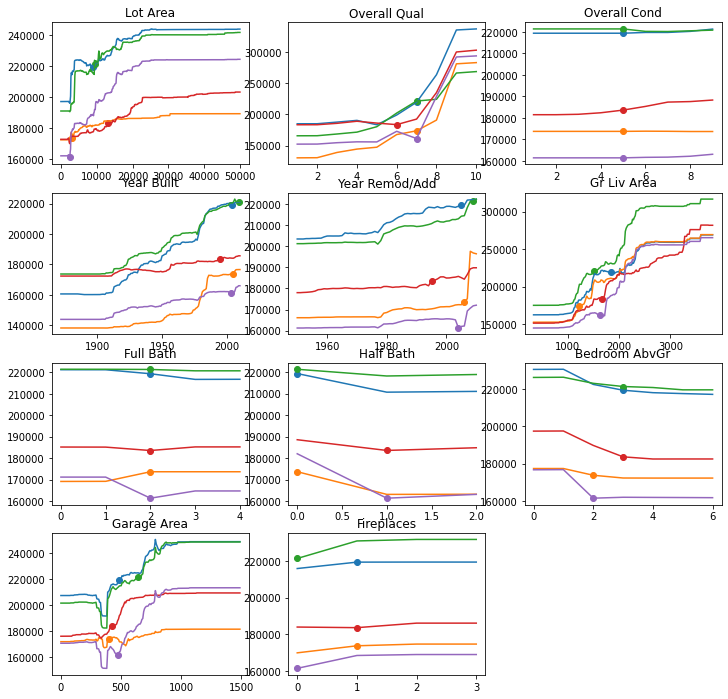

In [113]:
mli.ice_plot(rf1, test_pts, X_test_1.columns, range_pts=rd, pred_fn='predict')

## Interpreting ICE plots
Here are things you want to look for:
- When the line is flat, that means the variable is unimportant in that range (for that particular data point)
- When the line is steep, that means the variable has a strong effect on the target in that range.
- If the line is very wiggly, this often betrays some degree of "overfitting" in the model.  Interestingly, this is often *not* reflected in the test set metrics.  However, it is reflective of the "coherence" of the model.  It also may reflect a paucity of training data in that region
- If all the lines show the same basic effect, this suggests that there is little interaction.
- If some lines have very different trajectories, this indicates a high degree of interactivity.



NOTE: ICE-plots tell you what the *model* thinks.  To the extent that the model is reflective of the "real world" that generated the data, it may be useful in understanding the real world.  However, it may also be demonstrating places where the model is wrong, has little data, or is displaying artifacts of the way it was trained.  This is where our "human" thinking can be combined with the model to try and understand the world better.

### Comprehension Questions
- Which variables seem most important (globally) to the model?
- Which variables seem least important?

<br>

In [114]:
df_house.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [115]:
feat_2 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF']

In [116]:
X_train_2 = X_train_full.loc[:, feat_2]
y_train_2 = y_train
X_test_2 = X_test.loc[:, feat_2]

In [117]:
xgb_md1 = xgb.XGBRegressor(max_depth=1, 
                        n_estimators=1000, learning_rate=.05,
                           early_stopping_rounds = 50)

xgb_md1.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], 
        verbose=0)

preds_xgb_md1 = xgb_md1.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md1)), mean_absolute_error(y_test, preds_xgb_md1)

(23693.670559944218, 17123.170458984376)

In [118]:
xgb_md3 = xgb.XGBRegressor(max_depth=3, 
                        n_estimators=1000, learning_rate=.05,
                          early_stopping_rounds = 50)

xgb_md3.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], 
         verbose=0)

preds_xgb_md3 = xgb_md3.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md3)), mean_absolute_error(y_test, preds_xgb_md3)

(21536.858562605154, 15672.392177734375)

In [119]:
xgb_md6 = xgb.XGBRegressor(max_depth=6, 
                        n_estimators=1000, learning_rate=.05, 
        early_stopping_rounds = 50)

xgb_md6.fit(X_train_2, y_train_2, 
         eval_set=[(X_test_2, y_test)], verbose=0)

preds_xgb_md6 = xgb_md6.predict(X_test_2)

np.sqrt(mean_squared_error(y_test, preds_xgb_md6)), mean_absolute_error(y_test, preds_xgb_md6)

(22489.905101252094, 15690.500712890625)

In [120]:
rd2 = mli.get_range_dict(X_test_2)
rd2['Lot Area'] = np.linspace(0,50000,501)
test_pts_2 = X_test_2.sample(5, random_state=1)


Next, let's make ICE plots of all variables for the 3 models above.

- What differences do you notice across the 3 models?
- Compare the patterns in the following 3 variables:
    - Lot Area
    - Gr Liv Area
    - Garage Area

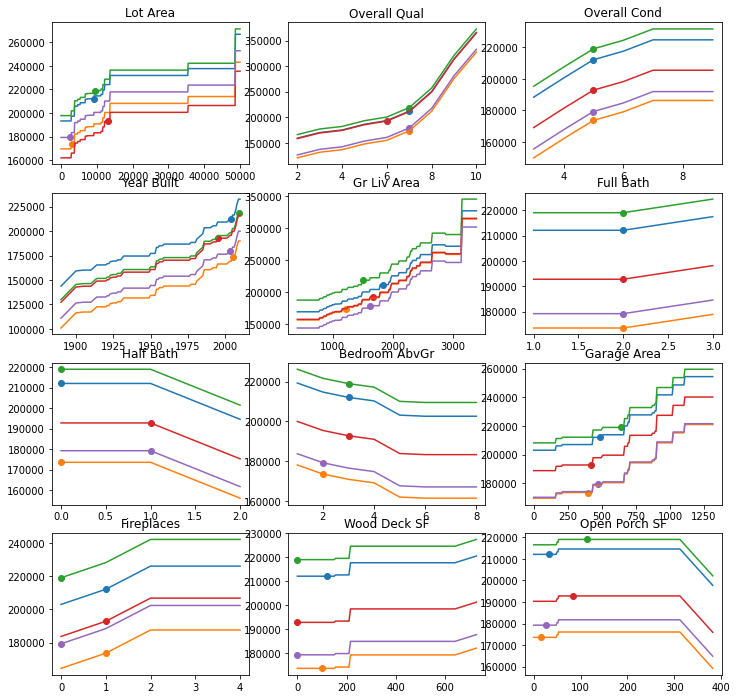

In [121]:
mli.ice_plot(xgb_md1, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

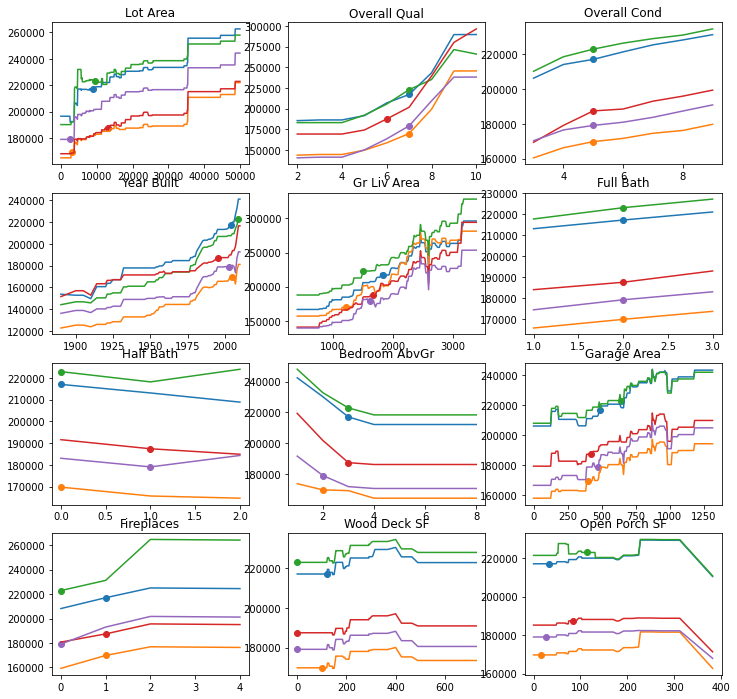

In [122]:
mli.ice_plot(xgb_md3, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

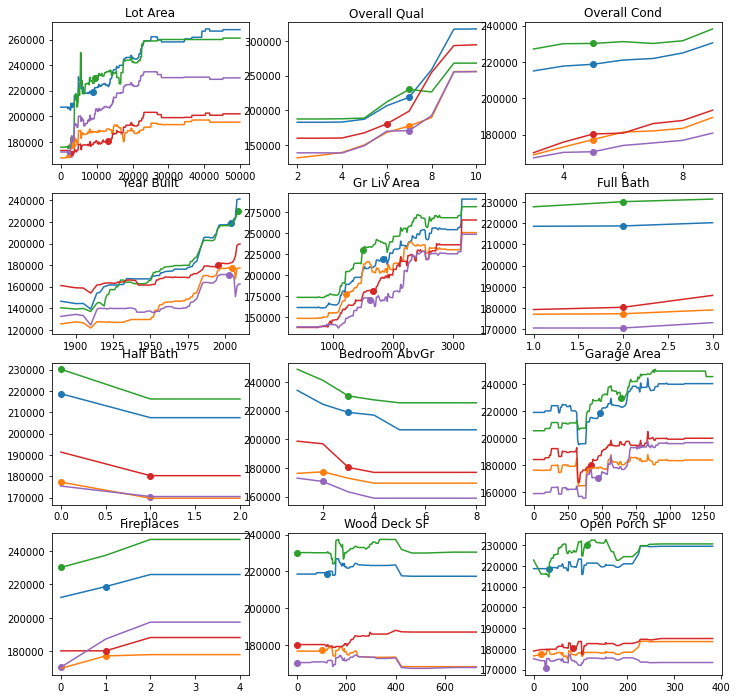

In [123]:
mli.ice_plot(xgb_md6, test_pts_2, X_test_2.columns, range_pts=rd2, pred_fn='predict')

In [124]:
feat_3 = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces',
          'Wood Deck SF', 'Open Porch SF', 'Neighborhood']

In [125]:
X_train_3 = X_train_full.loc[:, feat_3]
y_train_3 = y_train
X_test_3 = X_test.loc[:, feat_3]

In [126]:
cb3 = cb.CatBoostRegressor(n_estimators=10000, learning_rate=.01, max_depth=5,
                          early_stopping_rounds=50, eval_metric='RMSE', cat_features=['Neighborhood'])

cb3.fit(X_train_3, y_train_3, eval_set=[(X_test_3, y_test)], verbose=0)

cb3_preds = cb3.predict(X_test_3)
np.sqrt(mean_squared_error(y_test, cb3_preds))

20474.438123349337

In [127]:
rd3 = mli.get_range_dict(X_train_3)
rd3['Lot Area'] = np.linspace(0,50000,501)
test_pts_3 = X_test_3.sample(5, random_state=1)

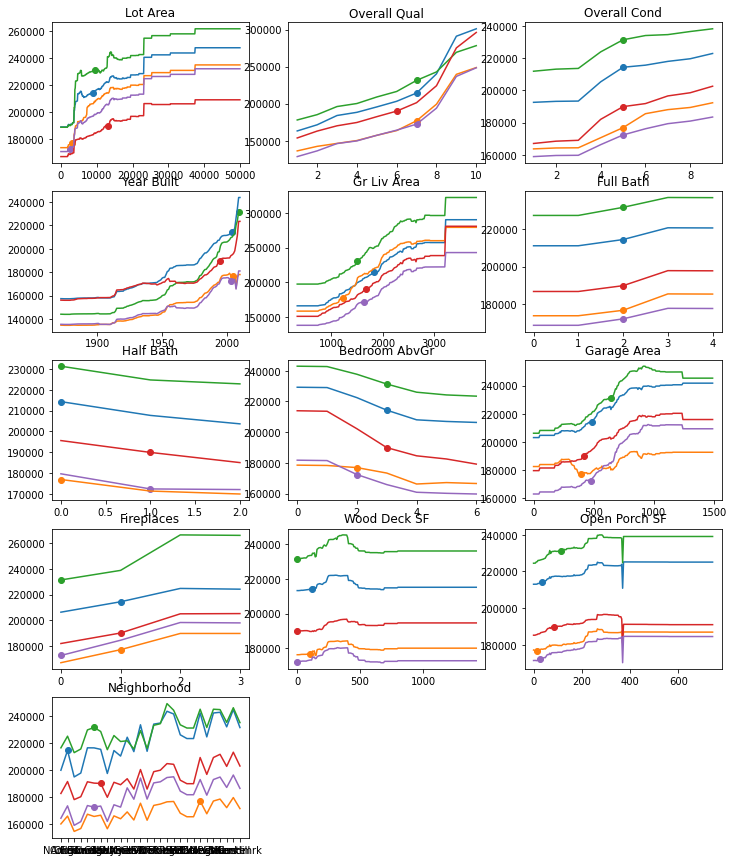

In [128]:
mli.ice_plot(cb3, test_pts_3, X_test_3.columns, range_pts=rd3, pred_fn='predict')

In [129]:
neigh_list = df_house.groupby(['Neighborhood']).SalePrice.mean().sort_values().index
rd3['Neighborhood'] = neigh_list

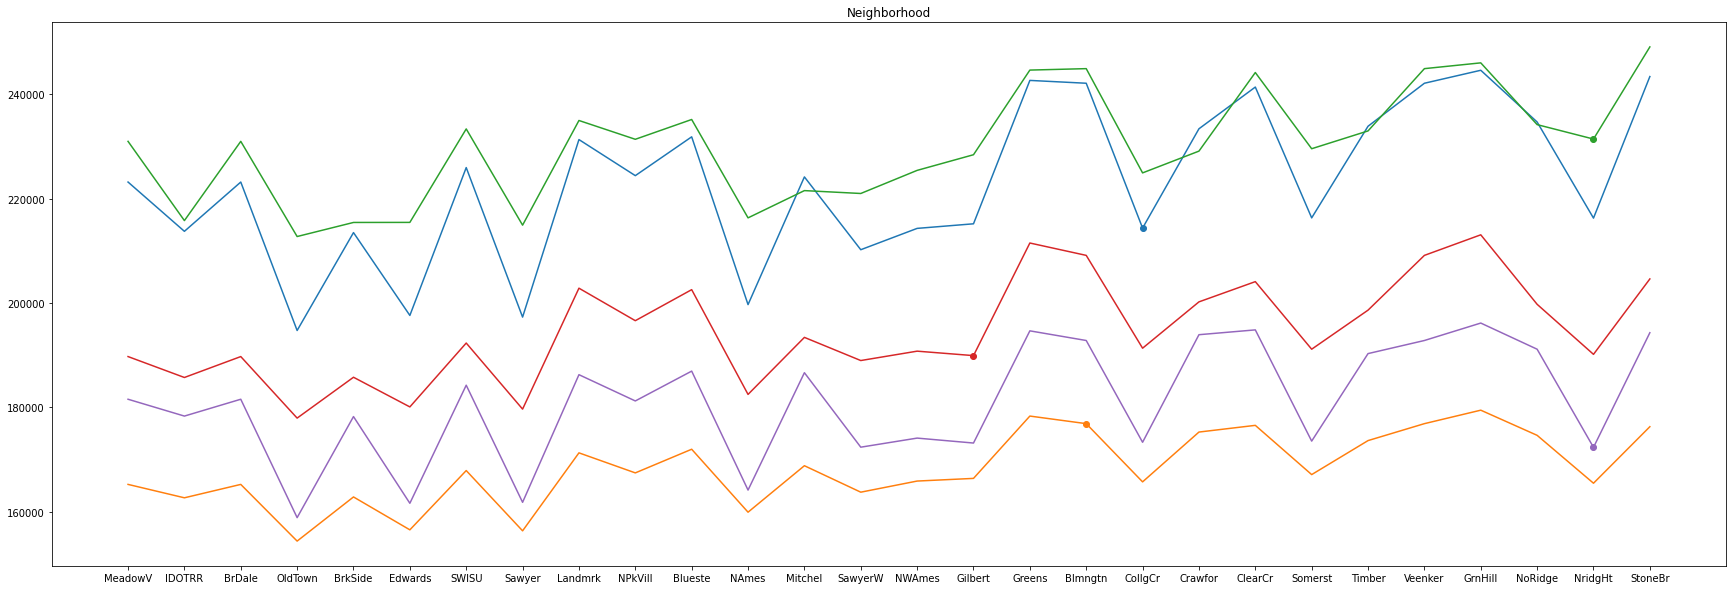

In [130]:
mli.ice_plot(cb3, test_pts_3, 'Neighborhood', range_pts=rd3, pred_fn='predict',
            figsize=(30,10))

## Exercise
Look at all the plots above and decide which one make sense, and which seem "suspicious" or unreliable

## Explaining Individual Predictions with SHAP


- In the previous, we focused our attention to understanding the overall dynamics of the model.

- However, in many cases,  we want to understand the reasons behind a specific prediction.

## Goal: 
- Explain why a particular instance is "different" from average.
- Which features / concepts contributed most to its "distinctiveness"?
- Can we attribute the "distance from average" of a particular case to the individual features?


## SHAP

### Idea: 

- #### arbitrarily order the features $X_1, X_2, \ldots, X_k$.

- #### Compare $E(Y|X_1 = x_1, X_2 = x_2, \ldots, X_{j-1}=x_{j-1})$ to $E(Y|X_1 = x_1, X_2 = x_2, \ldots, X_j=x_j)$ (actually, compare the log odds) and attribute the difference to feature $X_j$ being equal to $x_j$.

- #### Average the "attributions" to a feature over all possible orderings of the features

### This is motivated by the "Shapley Value" in Game Theory 
### Same approach attributes ~98% of the "power" in the Security Council to the 5 permanent members

The "magic" of SHAP is that step (3) (averaging over all possible orderings) is typically computationally prohibitive, but for tree-based models they found a clever way to compute "it" efficiently.

### End Result
Given a particular data point and its prediction, we can assign numerical values to each feature such that the sum of those values represents the distance between the "baseline" average and the predicted value.

### References
*A Unified Approach to Interpreting Model Predictions*
Scott Lundberg, Su-In Lee
https://arxiv.org/abs/1705.07874

*Consistent Individualized Feature Attribution for Tree Ensembles*
Scott M. Lundberg, Gabriel G. Erion, Su-In Lee
https://arxiv.org/abs/1802.03888


### Getting the SHAP values
There are multiple ways to get SHAP values.  The SHAP package has a "TreeExplainer" which works with sklearn, CatBoost, LightGBM, XGBoost.  Additionally, the individual packages have their own methods for getting the values, which vary from package to package.

In [131]:
import shap
shap.__version__
## may give annoying warnings...

'0.42.0'

In [132]:
tree_expl_cb3 = shap.TreeExplainer(cb3)
shap_val = tree_expl_cb3(X_test_3)

In [133]:
type(shap_val)

shap._explanation.Explanation

In [134]:
# The shap._explanation.Explanation object has 3 attributes
# .values (the values corresponding to each feature)
# .base_values (the intercept values that we "start" from)
# .data (A copy of the data it was applied to)
# We will take this info and put it into a DataFrame for easier reference
sv_df = pd.DataFrame(shap_val.values, columns=X_test_3.columns)
sv_df['Intercept'] = shap_val.base_values

In [135]:
sv_df.head()

Lot Area  Overall Qual  Overall Cond    Year Built   Gr Liv Area  \
0   601.662303   -638.403927  -1488.821540  14674.420996  15454.775905   
1 -4554.831627  -9435.710272 -13189.474831 -27481.441109 -16468.135778   
2 -6979.068677  22793.961027  -1575.359972  23308.239090  24663.370881   
3  1407.829801 -22258.793657  -2683.233927  -8279.223709 -20081.496886   
4 -2515.242218 -22710.080749   7779.715958 -26988.668455 -12459.518869   

     Full Bath    Half Bath  Bedroom AbvGr   Garage Area   Fireplaces  \
0  1872.933114 -1206.737626   -1324.614689   3664.195953  4288.334792   
1 -2792.529878  -691.049140      91.034625  -6553.054588 -6962.214937   
2  1469.901312 -1192.899139   -2043.575102  25097.049916  4140.965854   
3 -2844.897352  -244.105987     594.853141  -6719.600127 -6766.950644   
4 -2773.192907  -619.479540     248.935146  -4996.911542 -7389.715687   

   Wood Deck SF  Open Porch SF  Neighborhood      Intercept  
0   2005.912525    3168.584494   1494.550168  180855.333386  
1  -1379.857279    -384.473763  -7918.734380  180855.333386  
2   2584.680934    -574.126607    378.736407  180855.333386  
3  -1519.492729   -1613.767914  -5094.583530  180855.333386  
4  -1012.202835   -1071.670484  -8282.751530  180855.333386

In [136]:
# Alternate way to get same info in CatBoost directly
shap_values_2 = cb3.get_feature_importance(cb.Pool(X_test_3, cat_features=['Neighborhood']), 
                                                                     type="ShapValues")

sv_df_2 = pd.DataFrame(shap_values_2, columns = list(X_test_3.columns) + ['Intercept'])
np.allclose(sv_df.values, sv_df_2.values)

True

### OK, what do these numbers mean
- For each prediction, we can "decompose" it into a sum of contributions from each feature
- The Intercept represents what we would predict if we knew nothing about the house
- The feature-specific SHAP values represent, (on average) how much (and in what direction) the model "revised its opinion" upon learning that feature value.

Let's walk through an example

In [137]:
np.mean(y_train_2)

180853.18297029703

In [138]:
test_point = 2
np.sum(sv_df.iloc[test_point,:]), cb3_preds[test_point]

(272927.2093103659, 272927.2093103657)

In [139]:
# The values of the features, and the contribution to the final score
pd.concat((X_test_3.iloc[test_point,:], sv_df.iloc[test_point,:-1]), axis=1)

1797          2   
Lot Area          9000  -6979.068677
Overall Qual         8  22793.961027
Overall Cond         5  -1575.359972
Year Built        2006  23308.239090
Gr Liv Area       1959  24663.370881
Full Bath            2   1469.901312
Half Bath            1  -1192.899139
Bedroom AbvGr        3  -2043.575102
Garage Area     1025.0  25097.049916
Fireplaces           1   4140.965854
Wood Deck SF       208   2584.680934
Open Porch SF       46   -574.126607
Neighborhood   Somerst    378.736407

#### Force Plot in SHAP

In [140]:
shap.initjs()

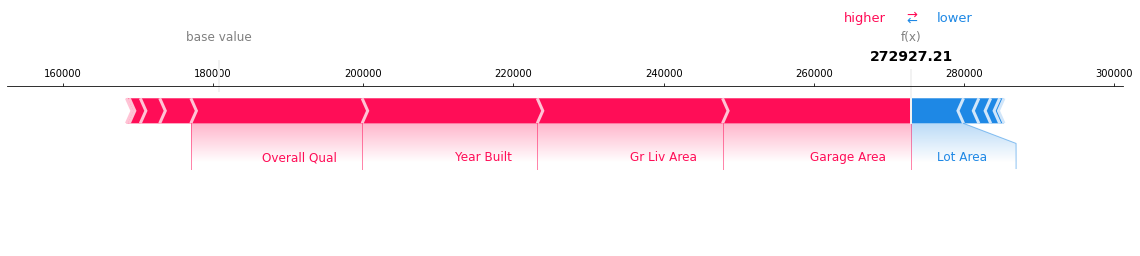

In [141]:
shap.force_plot(tree_expl_cb3.expected_value, sv_df.iloc[test_point,:-1].values, feature_names=X_test_3.columns,matplotlib=True)

### Global importances
One way to get a sense of how "globally" important a feature is to aggregate the (absolute value of) the local feature values.  This can be done easily in Pandas.

The numbers can be thought of as the "average absolute impact" that a variable has on the prediction.


In [142]:
# Fireplaces is interesting here...
feat_imp = sv_df.abs().mean().sort_values(ascending=False)
feat_imp

Intercept        180855.333386
Gr Liv Area       19107.988778
Year Built        14650.166397
Overall Qual      14361.016695
Lot Area           7327.934915
Fireplaces         7241.063246
Garage Area        6340.813847
Neighborhood       5870.283295
Overall Cond       4309.542255
Full Bath          2529.522242
Bedroom AbvGr      2105.085131
Open Porch SF      2083.969614
Wood Deck SF       1876.170571
Half Bath           796.079520
dtype: float64

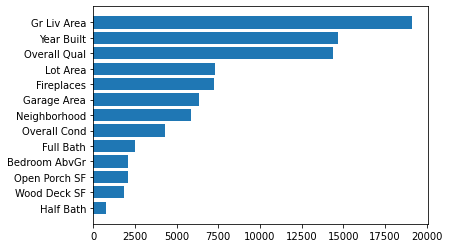

In [143]:
# Removed intercept from plot
plt.barh(feat_imp.index[1:][::-1], feat_imp.values[1:][::-1]);

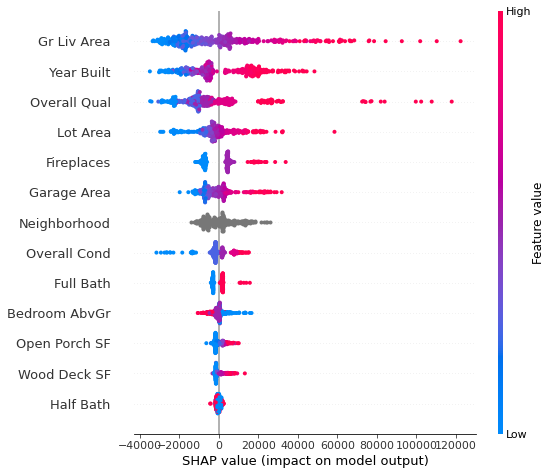

In [144]:
shap.summary_plot(shap_val.values, X_test_3)

In [145]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(sv_df.values[:,:-1].T), decimals=2), columns = sv_df.columns[:-1], index = sv_df.columns[:-1])

Lot Area  Overall Qual  Overall Cond  Year Built  Gr Liv Area  \
Lot Area           1.00          0.21          0.09        0.06         0.48   
Overall Qual       0.21          1.00          0.04        0.58         0.37   
Overall Cond       0.09          0.04          1.00       -0.10         0.04   
Year Built         0.06          0.58         -0.10        1.00         0.23   
Gr Liv Area        0.48          0.37          0.04        0.23         1.00   
Full Bath          0.25          0.35         -0.09        0.51         0.56   
Half Bath          0.03          0.20          0.19        0.01        -0.09   
Bedroom AbvGr     -0.12          0.21          0.03        0.14        -0.29   
Garage Area        0.33          0.55          0.01        0.47         0.42   
Fireplaces         0.28          0.33          0.10        0.15         0.48   
Wood Deck SF       0.26          0.13         -0.02        0.15         0.35   
Open Porch SF      0.16          0.21          0.03        0.36         0.31   
Neighborhood       0.20          0.59          0.02        0.62         0.42   

               Full Bath  Half Bath  Bedroom AbvGr  Garage Area  Fireplaces  \
Lot Area            0.25       0.03          -0.12         0.33        0.28   
Overall Qual        0.35       0.20           0.21         0.55        0.33   
Overall Cond       -0.09       0.19           0.03         0.01        0.10   
Year Built          0.51       0.01           0.14         0.47        0.15   
Gr Liv Area         0.56      -0.09          -0.29         0.42        0.48   
Full Bath           1.00      -0.09          -0.16         0.31        0.23   
Half Bath          -0.09       1.00           0.26         0.07        0.14   
Bedroom AbvGr      -0.16       0.26           1.00         0.08        0.06   
Garage Area         0.31       0.07           0.08         1.00        0.26   
Fireplaces          0.23       0.14           0.06         0.26        1.00   
Wood Deck SF        0.24       0.03          -0.14         0.12        0.26   
Open Porch SF       0.27      -0.13          -0.06         0.20        0.14   
Neighborhood        0.46       0.12           0.09         0.37        0.34   

               Wood Deck SF  Open Porch SF  Neighborhood  
Lot Area               0.26           0.16          0.20  
Overall Qual           0.13           0.21          0.59  
Overall Cond          -0.02           0.03          0.02  
Year Built             0.15           0.36          0.62  
Gr Liv Area            0.35           0.31          0.42  
Full Bath              0.24           0.27          0.46  
Half Bath              0.03          -0.13          0.12  
Bedroom AbvGr         -0.14          -0.06          0.09  
Garage Area            0.12           0.20          0.37  
Fireplaces             0.26           0.14          0.34  
Wood Deck SF           1.00           0.12          0.20  
Open Porch SF          0.12           1.00          0.31  
Neighborhood           0.20           0.31          1.00

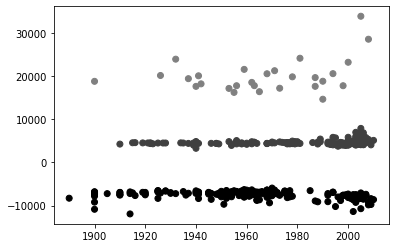

In [146]:
# Let's look at the interactivity between Year Built and value of a Fireplace
plt.scatter(X_test_3['Year Built'],sv_df['Fireplaces'],  c=X_test_3['Fireplaces'], cmap='gray');

# Thanks!!